## 1. Basic function

The following function have been defined in this section
- gen_lattice_2D_square_lattice
- MC_step_square
- Energy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
"""
Here generate a L x L 2D square matrix
The structure of matrix is like
{index(int):{'spin': -1, 'neighbours': (1, 1, 2, 2)}, ... }

"""

def gen_lattice_2D_square_lattice(L):
  lattice_dict={}
  N = L*L
  for i in range(N):
    temp = {"spin":np.random.choice([1,-1])}
    # Move to certain y level
    # Add x back
    x,y = i%L, i//L
    left_index = (x-1)%L + y*L
    right_index = (x+1)%L + y*L
    up_index = x + ((y-1)%L)*L
    down_index = x + ((y+1)%L)*L
    temp["neighbours"] = (left_index,right_index,up_index,down_index)
    lattice_dict[i] = temp

  return lattice_dict

In [ ]:
# Energy
def Energy(lattice_dict,L):
  Energy = 0
  for i in range(L*L):
    S = lattice_dict[i]['spin']

    Neighbour_sum = 0
    for j in lattice_dict[i]['neighbours']:
      Neighbour_sum+=lattice_dict[j]['spin']

    Energy += -S*Neighbour_sum
  # I divide Neighbour_sum by 2 to deal with overcounting
  return float(Energy)/2

# Absolute value of magnetization (lower case m)
def M(lattice_dict,L):
  M = 0
  for i in lattice_dict.values():
    M+=i["spin"]
  M = abs(M/(L*L))
  return M

# magnetization*2 (for computing Binder ratio)
def m_square(lattice_dict,L):
  M = 0
  for i in lattice_dict.values():
    M+=i["spin"]
  m = (M/(L**2))
  return m**(2)

# magnetization*4 (for computing Binder ratio)
def m_power_4(lattice_dict,L):
  M = 0
  for i in lattice_dict.values():
    M+=i["spin"]
  m = M/L**2
  return m**(4)

# specific_heat
def specific_heat(L,T,Energy_list):
  N = L**2
  Energy_mean = np.mean(Energy_list)
  Energy_square_mean =np.mean(np.square(Energy_list))
  return 1/(N*T)*(Energy_square_mean - Energy_mean**2)

# susceptibility
def susceptibility(L,T,M_list):
  N = L*L
  M_list = [i*N for i in M_list]
  M_mean = np.mean(np.abs(M_list))
  M_square_mean = np.mean(np.square(M_list))
  return (M_square_mean - M_mean**2)/(N*T)

Referencing the AW Sandvisk lecture note

- Using 1D array
- locating the position of spin
- Better store the neighbour of spin in dict for non-cubic lattice

## 2. Ising Model - Metropolis algorithm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
"""
MC step

This function will perform 1 MC step for square lattice

Parameters
----------
1. lattice_dict
 {index(int):{'spin': -1, 'neighbours': (1, 1, 2, 2)}, ... }
2. T - temperature
3. L - the length of a square lattice
-------

Return
----------
1. lattice_dict - the flipped lattice_dict

-------

"""
def MC_step_square(lattice_dict,T,L):

  for j in range(L*L):
    index = np.random.randint(0,L*L)

    spin_at_index = lattice_dict[index]["spin"]

    Neighbour_sum = 0

    for i in lattice_dict[index]['neighbours']:
      Neighbour_sum+=lattice_dict[i]['spin']

    delta_E = 2*spin_at_index*Neighbour_sum

    if delta_E < 0 or (np.random.rand() < np.exp(-delta_E/T)):
      lattice_dict[index]['spin'] *= -1

  return lattice_dict

### Check the value of thermalization

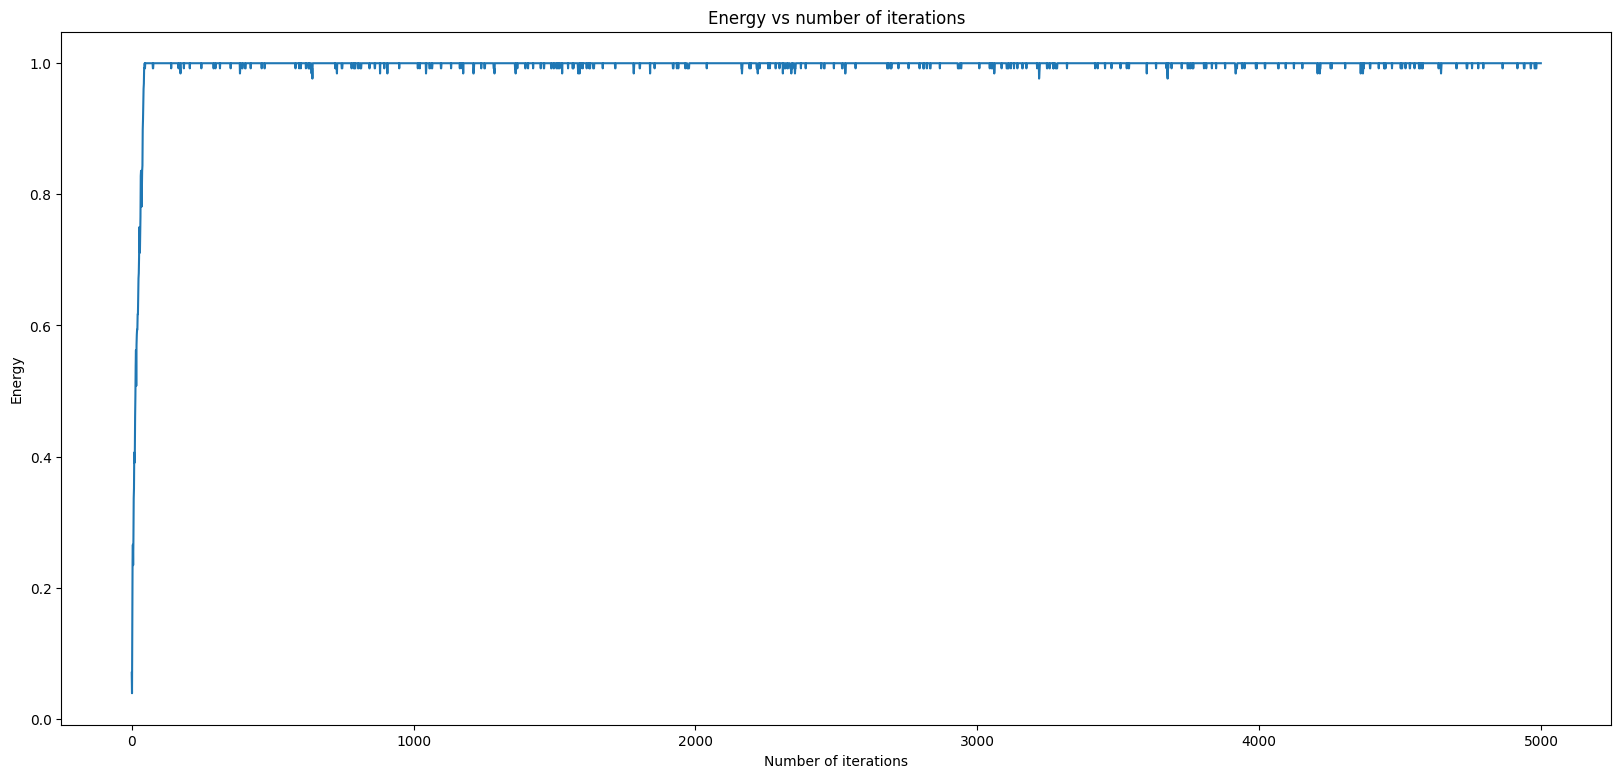

In [ ]:
def Q1_return(Temperature,iteration,L):
  M_list = []
  lattice_dict = gen_lattice_2D_square_lattice(L)

  for i in range(iteration):
    lattice_dict = MC_step_square(lattice_dict,Temperature,L)
    M_list.append(M(lattice_dict,L))

  return M_list

Temperature = 1
Iterations = 5000
L = 16
plt.figure(figsize=(20,9))
Energy_list = Q1_return(Temperature,Iterations,L)

plt.plot([i for i in range(0,Iterations)],Energy_list)

plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.title("Energy vs number of iterations")
plt.show()

### Metropolis_algorithm

In [ ]:
"""
Metropolis_algorithm

temp_dict has the structure
{"Energy per N":[],"m^2":[],"|m|":[]}

expect_dict has the structure
{"Energy per N":[],"m^2":[],"|m|":[],"specific heat":[],"suspectility":[]}

Parameters
----------
1. lattice_dict
 {index(int):{'spin': -1, 'neighbours': (1, 1, 2, 2)}, ... }
2. T - temperature
3. L - the length of a square lattice
-------

Return
----------
1. expect_dict - it contains the mean value of (iterations num times) of  "Energy per N" ,"m^2" ,"|m|" ,"specific heat" ,"suspectility"
                  at a particular temperature
It has the structure
{"Energy per N":[],"m^2":[],"|m|":[],"specific heat":[],"suspectility":[]}

2.sd_dict - it contains the standard deviation of (iterations num times) of  "Energy per N" ,"m^2" ,"|m|" ,"specific heat" ,"suspectility"
                  at a particular temperature
It has the structure
{"Energy per N":[],"m^2":[],"|m|":[],"specific heat":[],"suspectility":[]}
-------

"""

def metropolis_algo_at_T(Temperature,iteration,L):

#1. Generate equilibrium lattice
  lattice_dict = gen_lattice_2D_square_lattice(L)
  for i in range(4000):
    lattice_dict = MC_step_square(lattice_dict,Temperature,L)

 #2. Keep on running,collect data
  expect_dict = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[]}
  sd_dict = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[]}
  temp_dict={"Energy per N":[],"Absolute M":[],"Energy":[],"M^2":[]}

  for i in range(iteration):
    lattice_dict = MC_step_square(lattice_dict,Temperature,L)
    temp_dict["Energy"].append(Energy(lattice_dict,L))
    temp_dict["Energy per N"].append(Energy(lattice_dict,L)/(L**2))
    temp_dict["Absolute M"].append(M(lattice_dict,L))
    temp_dict["M^2"].append(M(lattice_dict,L)**2)


    if i%100==0 and i!=0:
      expect_dict["suspectility"].append(susceptibility(L,Temperature,temp_dict["Absolute M"]))
      expect_dict["specific heat"].append(specific_heat(L,Temperature,temp_dict["Energy"]))

      expect_dict["Energy per N"].append(np.mean(temp_dict["Energy per N"]))
      expect_dict["Absolute M"].append(np.mean(temp_dict["Absolute M"]))

      #clear the dictionary
      temp_dict.fromkeys(temp_dict,[])

  ## Take mean
  for i in expect_dict.keys():
    sd_dict[i] = np.std(expect_dict[i])
    expect_dict[i] = np.mean(expect_dict[i])

  print("Complete collecting data at temperature = {:.2f}".format(Temperature))

  return expect_dict,sd_dict

In [ ]:
L = 10
iteration = 1000
T = np.linspace(0.25,4,16)

final_mean_dict_mc = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[]}
final_sd_dict_mc = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[]}
for i in range(0,len(T)):

    expect_dict, sd_dict = metropolis_algo_at_T(T[i],iteration,L)

    for i in expect_dict.keys():
      final_mean_dict_mc[i].append(float(expect_dict[i]))
      final_sd_dict_mc[i].append(float(sd_dict[i]))


Complete collecting data at temperature = 0.25
Complete collecting data at temperature = 0.50
Complete collecting data at temperature = 0.75
Complete collecting data at temperature = 1.00
Complete collecting data at temperature = 1.25
Complete collecting data at temperature = 1.50
Complete collecting data at temperature = 1.75
Complete collecting data at temperature = 2.00
Complete collecting data at temperature = 2.25
Complete collecting data at temperature = 2.50
Complete collecting data at temperature = 2.75
Complete collecting data at temperature = 3.00
Complete collecting data at temperature = 3.25
Complete collecting data at temperature = 3.50
Complete collecting data at temperature = 3.75
Complete collecting data at temperature = 4.00


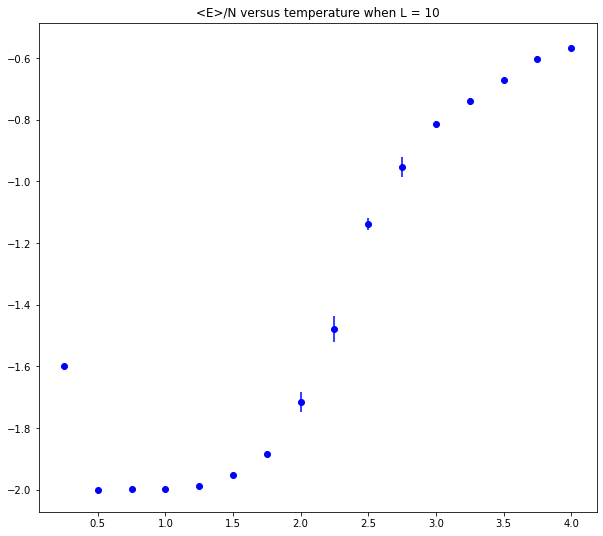

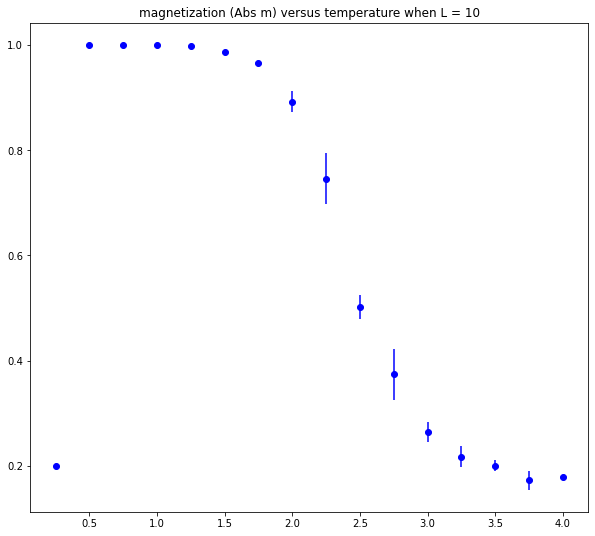

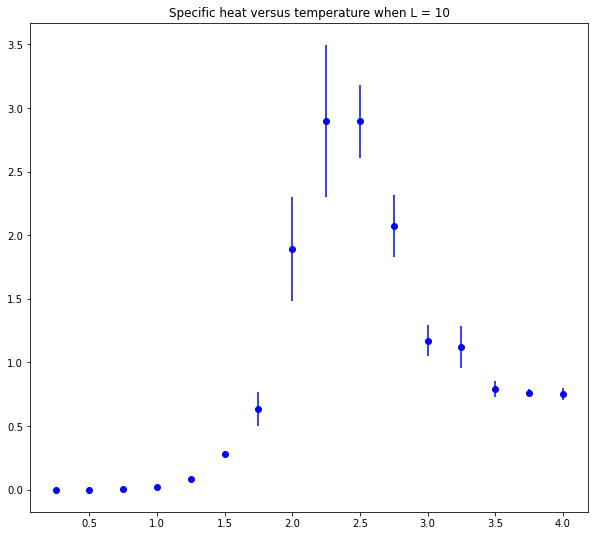

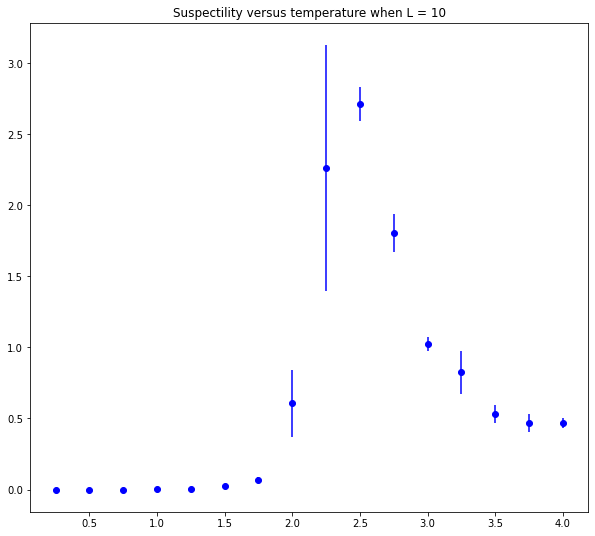

In [ ]:
#plot graph
#T = np.linspace(0.25,4,16)

#<E>/N
plt.figure(figsize=(10,9))
plt.errorbar(T,final_mean_dict_mc["Energy per N"],final_sd_dict_mc["Energy per N"],fmt='o',color="blue")
plt.title("<E>/N versus temperature when L = {l}".format(l = L))
plt.show()

#Absolute m
plt.figure(figsize=(10,9))
plt.errorbar(T,final_mean_dict_mc["Absolute M"],final_sd_dict_mc["Absolute M"],fmt='o',color="blue")
plt.title("magnetization (Abs m) versus temperature when L = {l}".format(l = L))
plt.show()

#specific heat
plt.figure(figsize=(10,9))
plt.errorbar(T,final_mean_dict_mc["specific heat"],final_sd_dict_mc["specific heat"],fmt='o',color="blue")
plt.title("Specific heat versus temperature when L = {l}".format(l = L))
plt.show()

#suspectility
plt.figure(figsize=(10,9))
plt.errorbar(T,final_mean_dict_mc["suspectility"],final_sd_dict_mc["suspectility"],fmt='o',color="blue")
plt.title("Suspectility versus temperature when L = {l}".format(l = L))
plt.show()


## 3. Ising Model - Wolff algorithm

Steps of implementing Wolff algorithm

- for different temperature:
    -  Thermalization
    -  for numbers of iterations
        -  get the clusters from return_cluster function
        -  flip every sites in the cluster set
    -  Record the status of the lattice



Main steps of one flips of Wolff's algorithm
1. Choose a site randomly
2. If the neighbouring sites are at the same state, add them to the cluster with probaility $p = 1 - e^{-2 \beta J}$ (for Ising model), where $\beta = \frac{1}{T}$ and J is the coupling constant (set to be 1)
3. Repeat this for every site on the boundaries until all bond of the cluster has been visited exactly once
4. Flip the cluster
  

In [ ]:
def wolff_step_square_BEF(lattice_dict,Temperature,L):

    p = 1 - np.exp(-2/Temperature*1)
    k=np.random.randint(0,L**2)
    Pocket = [k]
    Cluster = [k]
    N_cluster = 1

    while Pocket !=[]:
        s = np.random.choice(Pocket)
        for l in lattice_dict[s]["neighbours"]:
            if (lattice_dict[l]["spin"] == lattice_dict[k]["spin"]) and (l not in Cluster) and (np.random.random_sample()<p):
                N_cluster +=1
                Pocket.append(l)
                Cluster.append(l)
        Pocket.remove(s)

    for s in Cluster:
        lattice_dict[s]["spin"] *= -1

    return lattice_dict

In [ ]:
"""
Wolff algorithm

temp_dict has the structure
{"Energy per N":[],"m^2":[],"|m|":[],"M":[],"Energy":[]}

expect_dict has the structure
{"Energy per N":[],"m^2":[],"|m|":[],"specific heat":[],"suspectility":[]}
"""
def wolff_algo_at_T(Temperature,iteration,L):

#1. Generate equilibrium lattice
  lattice_dict = gen_lattice_2D_square_lattice(L)
  for i in range(2000):
    lattice_dict = wolff_step_square_BEF(lattice_dict,Temperature,L)

  #print("Finish in generating equilibrium lattice")
#2. Keep on running,collect data
  expect_dict = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[]}
  sd_dict = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[]}
  temp_dict={"Energy per N":[],"Absolute M":[],"Energy":[],"M^2":[]}

  for i in range(iteration):
    lattice_dict = wolff_step_square_BEF(lattice_dict,Temperature,L)
    temp_dict["Energy"].append(Energy(lattice_dict,L))
    temp_dict["Energy per N"].append(Energy(lattice_dict,L)/(L**2))
    temp_dict["Absolute M"].append(M(lattice_dict,L))
    temp_dict["M^2"].append((M(lattice_dict,L)/(L**2))**2)

    if i%100==0 and i!=0:
      expect_dict["suspectility"].append(susceptibility(L,Temperature,temp_dict["Absolute M"]))
      expect_dict["specific heat"].append(specific_heat(L,Temperature,temp_dict["Energy"]))

      expect_dict["Energy per N"].append(np.mean(temp_dict["Energy per N"]))
      expect_dict["Absolute M"].append(np.mean(temp_dict["Absolute M"]))

      #clear the dictionary
      temp_dict.fromkeys(temp_dict,[])

  ## Take mean
  for i in expect_dict.keys():
    sd_dict[i] = np.std(expect_dict[i])
    expect_dict[i] = np.mean(expect_dict[i])

  print("Complete collecting data at temperature = {:.2f}".format(Temperature))
  return expect_dict,sd_dict


In [ ]:
L = 10
iteration = 1000

final_mean_dict_wolff_BEF = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[]}
final_sd_dict_wolff_BEF = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[]}

for i in range(1,17):
    T = i*0.25
    expect_dict, sd_dict = wolff_algo_at_T(T,iteration,L)

    for i in expect_dict.keys():
      final_mean_dict_wolff_BEF[i].append(float(expect_dict[i]))
      final_sd_dict_wolff_BEF[i].append(float(sd_dict[i]))

In [ ]:
#plot graph
T = np.linspace(0.25, 4, 16)

#<E>/N
plt.figure(figsize=(20,9))
plt.errorbar(T,final_mean_dict_wolff_BEF["Energy per N"],final_sd_dict_wolff_BEF["Energy per N"],fmt='o',color="grey",label="Wolff-BEF")
plt.errorbar(T,final_mean_dict_mc["Energy per N"],final_sd_dict_mc["Energy per N"],fmt='o',color="red",label="MC")
plt.title("<E>/N versus temperature when L = {l}".format(l = L))
plt.legend()
plt.show()

#|m|
plt.figure(figsize=(20,9))
plt.errorbar(T,final_mean_dict_wolff_BEF['Absolute M'],final_sd_dict_wolff_BEF['Absolute M'],fmt='o',color="grey",label="Wolff-BEF")
plt.errorbar(T,final_mean_dict_mc['Absolute M'],final_sd_dict_mc['Absolute M'],fmt='o',color="red",label="MC")
plt.title("|m| versus temperature when L = {l}".format(l = L))
plt.legend()
plt.show()

#Specific heat
plt.figure(figsize=(20,9))
plt.errorbar(T,final_mean_dict_wolff_BEF['specific heat'],final_sd_dict_wolff_BEF['specific heat'],fmt='o',color="grey",label="Wolff-BEF")
plt.errorbar(T,final_mean_dict_mc['specific heat'],final_sd_dict_mc["specific heat"],fmt='o',color="red",label="MC")
plt.title("Specific heat versus temperature when L = {l}".format(l = L))
plt.legend()
plt.show()

#Suspectility
plt.figure(figsize=(20,9))
plt.errorbar(T,final_mean_dict_wolff_BEF["suspectility"],final_sd_dict_wolff_BEF["suspectility"],fmt='o',color="grey",label="Wolff-BEF")
plt.errorbar(T,final_mean_dict_mc["suspectility"],final_sd_dict_mc["suspectility"],fmt='o',color="red",label="MC")
plt.title("Suspectility versus temperature when L = {l}".format(l = L))
plt.legend()
plt.show()

### Test if the programme runs correctly (Wolff Algorithm)

The following section tests whether the energy of system would converage

In [ ]:
#For testing

def wolff_test_return(Temperature,iteration,L):
  Energy_list = []
  lattice_dict = gen_lattice_2D_square_lattice(L)

  for i in range(iteration):
    lattice_dict = wolff_step_square_BEF(lattice_dict,Temperature,L)
    Energy_list.append(Energy(lattice_dict,L))

  return Energy_list

iteration = 1000
Temperature = 1
L = 16
plt.figure(figsize=(20,9))
Energy_list =  wolff_test_return(Temperature,iteration,L)

plt.plot([i for i in range(0,iteration)],Energy_list)

plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.title("Energy vs number of iterations")
plt.show()

## 4. Ising Model - Swendsen-Wang algorithm

Steps of implementing Swendsen-Wang algorithm

- for different temperature:
    -  Thermalization
    -  for numbers of iterations
        -  Occupy the bond with $prob = 1 - e^{-2 \cdot \beta \cdot J}$ ,where J is coupling constant
        -  Use HK algo to indentify clusters
        -  Flip the clusters with 1/2 prob
    -  Record the status of the lattice

In [ ]:
"""
SW_algo_step_square

Description
- The following function is using BEF approach to implement SW algorithm

Parameters
----------
1. lattice_dict
 { index(int):{'spin': -1, 'neighbours': (1, 1, 2, 2), "bond": [down,right], visit = False}, ... }
2. T - temperature
3. L - the length of a square lattice
-------

Return
----------
1. lattice_dict - the flipped configurations

-------

"""

def SW_algo_step_square(lattice_dict, Temperature,L):
    #1. Generate bond configuration and set the ["visit"] first

    #print("Before finding bond configuration, ")
    #for i in range(0,len(lattice_dict)):
    #    print(lattice_dict[i])
    #    print("Bond [0] is {a}".format(a = lattice_dict[i]["bond"][0]))

    for i in range(0,len(lattice_dict)):
        lattice_dict[i]["notvisit"] = True
        lattice_dict[i]["bond"] = [0,0] # [down,right]

    beta = 1/Temperature
    prob = 1 - np.exp(-2*beta*1)

    for i in range(0,len(lattice_dict)):

        down = lattice_dict[i]["neighbours"][3]
        right = lattice_dict[i]["neighbours"][1]

        # Check if there is link with right sites with prob
        if lattice_dict[i]["spin"] == lattice_dict[down]["spin"]:
            if np.random.rand() < prob:
                lattice_dict[i]["bond"][0] = 1

                #print(lattice_dict[i]["spin"] == lattice_dict[down]["spin"])
                #print("Current site is  {cs}, it forms bond with {d} (downwards).".format(cs = i, d = down))

        # Check if there is link with sites down with prob
        if lattice_dict[i]["spin"] == lattice_dict[right]["spin"]:
            if np.random.rand() < prob:
                lattice_dict[i]["bond"][1] = 1
                #print("Current site is  {cs}, it forms bond with {r} (right).".format(cs = i, r = right))

    """
    print("At first, the cluster is: ")
    for i in range(0,len(lattice_dict)):
        print(str(i)+str(lattice_dict[i]))
    """

    for i in range(0,len(lattice_dict)):
        #print("Now at site {i}".format(i=i))
        if lattice_dict[i]["notvisit"]:

            if np.random.rand() < 0.5:
                flip_flag = True
                lattice_dict[i]["spin"] *=-1
                #print("Flip flag is True. Flip {i}".format(i=i))
            else:
                flip_flag = False

            lattice_dict[i]["notvisit"] = False

            stack_array = np.zeros((L*L))
            stack_array[0] = i
            nstack = 1

            """
            print("Flip flag is: {ff}".format(ff = flip_flag))
            print("Before flipping, the cluster is: ")
            for i in range(0,len(lattice_dict)):
            print(str(i)+str(lattice_dict[i]))
            """

            # Using Breadth-first search (BFS) Algorithm
            while nstack > 0:
                coor = int(stack_array[nstack-1])
                nstack -= 1

                left_coor = lattice_dict[coor]["neighbours"][0]
                right_coor = lattice_dict[coor]["neighbours"][1]
                up_coor = lattice_dict[coor]["neighbours"][2]
                downwards_coor = lattice_dict[coor]["neighbours"][3]

                # Check if it has bond with site located downwards
                if lattice_dict[coor]["bond"][0] and (lattice_dict[downwards_coor]["notvisit"]):
                    lattice_dict[downwards_coor]["notvisit"] = False

                    if flip_flag:
                        lattice_dict[downwards_coor]["spin"]*= -1
                        #print("Current position is {cs}, flip downwards {d}".format(cs = coor,d = downwards_coor))

                    nstack += 1
                    stack_array[nstack-1] = downwards_coor


                # Check if it has bond with site located on the right
                if lattice_dict[coor]["bond"][1] and (lattice_dict[right_coor]["notvisit"]):
                    lattice_dict[right_coor]["notvisit"] = False

                    if flip_flag:
                        lattice_dict[right_coor]["spin"]*= -1
                        #print("Current position is {cs}, flip right {r}".format(cs = coor,r =  right_coor))

                    nstack += 1
                    stack_array[nstack-1] = right_coor


                # Check if it has bond with site located upwards
                if lattice_dict[up_coor]["bond"][0] and (lattice_dict[up_coor]["notvisit"]):
                    lattice_dict[up_coor]["notvisit"] = False

                    if flip_flag:
                        lattice_dict[up_coor]["spin"]*= -1
                        #print("Current position is {cs}, flip up {up}".format(cs = coor,up =  up_coor))

                    nstack += 1
                    stack_array[nstack-1] = up_coor


                # Check if it has bond with site located on the left
                if lattice_dict[left_coor]["bond"][1] and (lattice_dict[left_coor]["notvisit"]):
                    lattice_dict[left_coor]["notvisit"] = False

                    if flip_flag:
                        lattice_dict[left_coor]["spin"]*= -1
                        #print("Current position is {cs}, flip left {l}".format(cs = coor,l =  left_coor))

                    nstack += 1
                    stack_array[nstack-1] = left_coor


            #print("Changing, the lattice is: ")
            #print(lattice_dict)

    return lattice_dict


In [ ]:
"""
SW_algo_step_square_hk
(The following code also uses this function)

1. Occupy the bond with prob 1 - e^{-2*beta*J}
2. Use HK algo to indentify clusters
3. Flip the clusters with 1/2 prob
4. Repeat  1->3

Parameters
----------
1. lattice_dict
 { index(int):{'spin': -1, 'neighbours': (1, 1, 2, 2), "bond": [left,up], visit = False, cluster = 0 }, ... }
2. Temperature
3. L - length of lattice

-------

Return
----------
1. lattice_dict - the flipped configurations

-------

"""

def SW_algo_step_square_HK(lattice_dict, Temperature,L):

    #1. Occupy the bond with prob 1 - e^{-2*beta*J}
    for i in range(0,len(lattice_dict)):
        lattice_dict[i]["bond"] = [0,0]
        lattice_dict[i]["cluster"] = 0

    """
    print("Before finding bond configuration, ")
    for i in range(0,len(lattice_dict)):
        print(lattice_dict[i])

    print("Bond [0] is {a}".format(a = lattice_dict[i]["bond"][0]))
    """

    beta = 1/Temperature
    prob = 1 - np.exp(-2*beta*1)

    for i in range(0,L*L):
        left_coor = lattice_dict[i]["neighbours"][0]
        up_coor = lattice_dict[i]["neighbours"][2]

        # Check if there is link with the sites on the left with prob
        if lattice_dict[i]["spin"] == lattice_dict[left_coor]["spin"]:
            if np.random.rand() <= prob:
                lattice_dict[i]["bond"][0] = 1

                """
                print(lattice_dict[i]["spin"] == lattice_dict[left_coor]["spin"])
                print("Current site is  {cs}, it forms bond with {l} (on the left).".format(cs = i, l = left_coor))
                """

        # Check if there is link with sites upwards with prob
        if lattice_dict[i]["spin"] == lattice_dict[up_coor]["spin"]:
            if np.random.rand() <= prob:
                lattice_dict[i]["bond"][1] = 1

                """
                print("Current site is  {cs}, it forms bond with {up_coor} (upwards).".format(cs = i, up_coor  = up_coor))
                """


    #2. Indentify the cluster with Hoshen-Kopelman algorithm
    """
    print("Before HK algo, the cluster is: ")
    for i in range(0,len(lattice_dict)):
        print(str(i)+str(lattice_dict[i]))
    print()
    """

    k = 2
    Mass_of_cluster_dict = dict()
    for i in range(0,L*L):

        """
        print("Current site is {cs}".format(cs=i))
        """

        left_coor = lattice_dict[i]["neighbours"][0]
        up_coor = lattice_dict[i]["neighbours"][2]

        # Situation 1: Set up a new cluster
        #  i) (Both left and up has bond) and both site ["cluster"] == 0
        #  ii) (Only 1 bond) and the site ["cluster"] == 0
        #  iii) No bond
        #  All of this situation -> set up a new cluster

        if (
            ((lattice_dict[i]["bond"] == [1,1]) and lattice_dict[left_coor]["cluster"] == lattice_dict[up_coor]["cluster"] == 0) or
            ((lattice_dict[i]["bond"] == [1,0]) and lattice_dict[left_coor]["cluster"] == 0) or
            ((lattice_dict[i]["bond"] == [0,1]) and lattice_dict[up_coor]["cluster"] == 0) or
            ((lattice_dict[i]["bond"] == [0,0]))
            ):

            """
            print("Situation 1: Set up a new cluster")
            print("The site is {cs}.It is belong to {k} clusters now".format(cs = i, k = k))
            """

            # Label the cluster to be k-th
            lattice_dict[i]["cluster"] = k

            # Initialize the mass of k-th cluster
            Mass_of_cluster_dict[k] = 1

            # Update k
            k+=1

            """
            print("The Mass_of_cluster_dict is {a}".format(a = Mass_of_cluster_dict))
            """

        # Situation 2: add to the cluster on the left
        #  i) (Both left and up have bond) and lattice_dict[left_coor]["cluster"] != 0 and lattice_dict[up_coor]["cluster"] == 0
        #  ii) (Only left has bond) and lattice_dict[left_coor]["cluster"] != 0

        #  All of this situation -> add to the cluster on the left

        elif (
            ((lattice_dict[i]["bond"] == [1,1]) and (lattice_dict[left_coor]["cluster"] != 0) and (lattice_dict[up_coor]["cluster"] == 0)) or
            ((lattice_dict[i]["bond"] == [1,0]) and lattice_dict[left_coor]["cluster"] != 0)
            ):

                left_coor_kth = lattice_dict[left_coor]["cluster"]

                """
                print("Situation 2: add to the cluster on the left")
                print("left_coor_kth is {left_coor_kth}".format(left_coor_kth=left_coor_kth))
                """

                # Check if the mass of clusters on the left is negative
                while (Mass_of_cluster_dict[left_coor_kth] < 0):
                    left_coor_kth = Mass_of_cluster_dict[left_coor_kth]*-1

                """
                print("After checking whether the site chosen is negative, ")
                print("left_coor_kth is {left_coor_kth}".format(left_coor_kth=left_coor_kth))
                """

                # Label the site to be the elements of the clusters on the left
                lattice_dict[i]["cluster"] = left_coor_kth

                # Update the weight of the left_coor_kth clusters
                Mass_of_cluster_dict[left_coor_kth] += 1

                """
                print("The site is {cs}.It is belong to {k} clusters now".format(cs = i, k = left_coor_kth))
                print("The Mass_of_cluster_dict is {a}".format(a = Mass_of_cluster_dict))
                """

        # Situation 3: add to the cluster upwards
        #  i) (Both left and up have bond) and lattice_dict[up_coor]["cluster"] != 0 and lattice_dict[left_coor]["cluster"] == 0
        #  ii) (Only up has bond) and lattice_dict[up_coor]["cluster"] != 0

        #  All of this situation -> add to the cluster upwards

        elif(
            ((lattice_dict[i]["bond"] == [1,1]) and (lattice_dict[up_coor]["cluster"] != 0) and (lattice_dict[left_coor]["cluster"] == 0)) or
            ((lattice_dict[i]["bond"] == [0,1]) and lattice_dict[up_coor]["cluster"] != 0)
            ):


                up_coor_kth = lattice_dict[up_coor]["cluster"]

                """
                print("Situation 3: add to the cluster upwards")
                print("up_coor_kth is {up_coor_kth}".format(up_coor_kth=up_coor_kth))
                """

                # Check if the mass of clusters upwards is negatice
                while (Mass_of_cluster_dict[up_coor_kth] < 0):
                    up_coor_kth = Mass_of_cluster_dict[up_coor_kth]*-1

                """
                print("After checking whether the site chosen is negative, ")
                print("up_coor_kth is {up_coor_kth}".format(up_coor_kth=up_coor_kth))
                """

                # Label the site to be the elements of the clusters upwards
                lattice_dict[i]["cluster"] = up_coor_kth

                # Update the weight of the up_coor_kth clusters
                Mass_of_cluster_dict[up_coor_kth] += 1

                """
                print("The site is {cs}.It is belong to {k} clusters now".format(cs = i, k = up_coor_kth))
                print("The Mass_of_cluster_dict is {a}".format(a = Mass_of_cluster_dict))
                """

        # Situation 4: Both up and left belongs to same clusters
        #  i) (Both left and up have bond) and lattice_dict[up_coor]["cluster"] == lattice_dict[left_coor]["cluster"]

        #  All of this situation -> add to the cluster upwards

        elif ((lattice_dict[i]["bond"] == [1,1]) and (lattice_dict[up_coor]["cluster"] == lattice_dict[left_coor]["cluster"] != 0)):

                up_coor_kth = lattice_dict[up_coor]["cluster"]

                """
                print("Situation 4: Both up and left belongs to same clusters")
                print("up_coor_kth is {up_coor_kth}".format(up_coor_kth=up_coor_kth))
                """

                # Check if the mass of clusters upwards is negative
                while (Mass_of_cluster_dict[up_coor_kth] < 0):
                    up_coor_kth = Mass_of_cluster_dict[up_coor_kth]*-1

                """
                print("After checking whether the site chosen is negative, ")
                print("up_coor_kth is {up_coor_kth}".format(up_coor_kth=up_coor_kth))
                """

                # Label the site to be the elements of the clusters upwards
                lattice_dict[i]["cluster"] = up_coor_kth

                # Update the weight of the up_coor_kth clusters
                Mass_of_cluster_dict[up_coor_kth] += 1

                """
                print("The site is {cs}.It is belong to {k} clusters now".format(cs = i, k = up_coor_kth))
                print("The Mass_of_cluster_dict is {a}".format(a = Mass_of_cluster_dict))
                """

        # Situation 5: Up and left belongs to different clusters
        #  i) (Both left and up have bond) and (lattice_dict[up_coor]["cluster"] != lattice_dict[left_coor]["cluster"])

        #  All of this situation -> combine the 2 clusters

        elif ((lattice_dict[i]["bond"] == [1,1]) and (lattice_dict[up_coor]["cluster"] != lattice_dict[left_coor]["cluster"] != 0)):

                """
                print("Situation 5: Up and left belongs to different clusters")
                """

                not_chosen_kth = lattice_dict[up_coor]["cluster"]
                chosen_kth = lattice_dict[left_coor]["cluster"]

                 # Check if the mass of clusters site of chosen site is negative
                while (Mass_of_cluster_dict[chosen_kth] < 0):
                    chosen_kth = Mass_of_cluster_dict[chosen_kth]*-1

                # Check if the mass of clusters site of not chosen site is negative
                while (Mass_of_cluster_dict[not_chosen_kth] < 0):
                    not_chosen_kth = Mass_of_cluster_dict[not_chosen_kth]*-1

                if chosen_kth == not_chosen_kth:

                    """
                    print("The 2 sites are indeed the same")
                    """


                    # Label the site
                    lattice_dict[i]["cluster"] = chosen_kth

                    # Update the weight of the up_coor_kth clusters
                    Mass_of_cluster_dict[chosen_kth] += 1

                    """
                    print("The chosen site is {chosen_kth}.".format(chosen_kth=chosen_kth))
                    print("The site is {cs}.It is belong to {k} clusters now".format(cs = i, k =  chosen_kth))
                    print("The Mass_of_cluster_dict is {a}".format(a = Mass_of_cluster_dict))
                    """

                else:

                    # Randomly choose up or left
                    if np.random.rand() < 0.5:
                        chosen_kth, not_chosen_kth = not_chosen_kth, chosen_kth

                    """
                    print("The chosen site is {chosen_kth}.The not chosen site is {not_chosen_kth}".format(chosen_kth=chosen_kth,not_chosen_kth = not_chosen_kth))
                    print("After checking whether the site chosen is negative, ")
                    """


                    # Label the site to be the elements of the clusters chosen
                    lattice_dict[i]["cluster"] = chosen_kth

                    # Update the weight of the up_coor_kth clusters
                    Mass_of_cluster_dict[chosen_kth] = Mass_of_cluster_dict[chosen_kth] + Mass_of_cluster_dict[not_chosen_kth] + 1
                    Mass_of_cluster_dict[not_chosen_kth] = -1*chosen_kth

                    """
                    print("The chosen site is {chosen_kth}.The not chosen site is {not_chosen_kth}".format(chosen_kth=chosen_kth,not_chosen_kth = not_chosen_kth))
                    print("The site is {cs}.It is belong to {k} clusters now".format(cs = i, k =  chosen_kth))
                    print("The Mass_of_cluster_dict is {a}".format(a = Mass_of_cluster_dict))
                    """



        else:
            # for checking
            print("Should not exist the except case")

        """
        print("After flipping, the lattice is ")
        for i in range(0,len(lattice_dict)):
            print(str(i)+str(lattice_dict[i]))
        print()
        """


    # 3. Flip the cluster with 1/2 prob
    bool_TF = (True,False)

    """
    The structures of Mass_of_cluster_dict has changed to
    {2:[Mass of cluster, bool1(Decide to flip or not)], ... , k:[Mass of cluster, bool1(Decide to flip or not)]}

    """
    for i in Mass_of_cluster_dict.keys():
        bool1 = np.random.choice(bool_TF)
        Mass_of_cluster_dict[i] = [Mass_of_cluster_dict[i],bool1]

    """
    print("After assigning the TF value, the Mass_of_cluster_dict is, ")
    print(Mass_of_cluster_dict)
    print()
    """

    for i in lattice_dict.keys():
        k = lattice_dict[i]["cluster"]

        while Mass_of_cluster_dict[k][0] < 0:
            k = Mass_of_cluster_dict[k][0]*(-1)

        if Mass_of_cluster_dict[k][1]:
            lattice_dict[i]["spin"]*=-1
            lattice_dict[i]["flip"] = True

        else:
            lattice_dict[i]["flip"] = False

    """
    print("After all, the lattice is ")
    for i in range(0,len(lattice_dict)):
        print(str(i)+str(lattice_dict[i]))
    print()
    """

    return lattice_dict


In [ ]:
"""
SW_algo_at_T

(Description)

Parameters
----------
1. Temperature
2. Iteration
3. L
-------

Return
----------
1. expect_dict,sd_dict  - similar to MC algo

-------

"""
def SW_algo_at_T(Temperature,iteration,L):

#1. Generate equilibrium lattice
  lattice_dict = gen_lattice_2D_square_lattice(L)
  for i in range(2000):
    lattice_dict = SW_algo_step_square(lattice_dict,Temperature,L)

  #print("Finish in generating equilibrium lattice")
#2. Keep on running,collect data
  expect_dict = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[],"m^2":[],"m^4":[]}
  sd_dict = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[],"m^2":[],"m^4":[]}
  temp_dict={"Energy per N":[],"Absolute M":[],"Energy":[],"m^2":[],"m^4":[]}

  for i in range(iteration):
    lattice_dict = SW_algo_step_square(lattice_dict,Temperature,L)
    temp_dict["Energy"].append(Energy(lattice_dict,L))
    temp_dict["Energy per N"].append(Energy(lattice_dict,L)/(L**2))
    temp_dict["Absolute M"].append(M(lattice_dict,L))

    # For computing binder ratio
    temp_dict["m^2"].append(m_square(lattice_dict,L))
    temp_dict["m^4"].append(m_power_4(lattice_dict,L))

    if i%100==0 and i!=0:
      expect_dict["suspectility"].append(susceptibility(L,Temperature,temp_dict["Absolute M"]))
      expect_dict["specific heat"].append(specific_heat(L,Temperature,temp_dict["Energy"]))

      expect_dict["Energy per N"].append(np.mean(temp_dict["Energy per N"]))
      expect_dict["Absolute M"].append(np.mean(temp_dict["Absolute M"]))

      # For computing binder ratio
      expect_dict["m^2"] = list(expect_dict["m^2"])
      expect_dict["m^4"] = list(expect_dict["m^4"])
      expect_dict["m^2"].append(np.mean(temp_dict["m^2"]))
      expect_dict["m^4"].append(np.mean(temp_dict["m^4"]))

      #clear the dictionary
      temp_dict.fromkeys(temp_dict,[])

  ## Take mean
  for i in expect_dict.keys():
    sd_dict[i] = np.std(expect_dict[i])
    expect_dict[i] = np.mean(expect_dict[i])


  print("Complete collecting data at temperature = {T}".format(T=Temperature))

  return expect_dict,sd_dict


In [ ]:
def SW_algo_at_T_HK(Temperature,iteration,L):

#1. Generate equilibrium lattice
  lattice_dict = gen_lattice_2D_square_lattice(L)
  for i in range(2000):
    lattice_dict = SW_algo_step_square_HK(lattice_dict,Temperature,L)

  #print("Finish in generating equilibrium lattice")
#2. Keep on running,collect data
  expect_dict = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[],"m^2":[],"m^4":[]}
  sd_dict = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[],"m^2":[],"m^4":[]}
  temp_dict={"Energy per N":[],"Absolute M":[],"Energy":[],"m^2":[],"m^4":[]}

  for i in range(iteration):
    lattice_dict = SW_algo_step_square_HK(lattice_dict,Temperature,L)
    temp_dict["Energy"].append(Energy(lattice_dict,L))
    temp_dict["Energy per N"].append(Energy(lattice_dict,L)/(L**2))
    temp_dict["Absolute M"].append(M(lattice_dict,L))

    # For computing binder ratio
    temp_dict["m^2"].append(m_square(lattice_dict,L))
    temp_dict["m^4"].append(m_power_4(lattice_dict,L))

    if i%100==0 and i!=0:
      expect_dict["suspectility"].append(susceptibility(L,Temperature,temp_dict["Absolute M"]))
      expect_dict["specific heat"].append(specific_heat(L,Temperature,temp_dict["Energy"]))

      expect_dict["Energy per N"].append(np.mean(temp_dict["Energy per N"]))
      expect_dict["Absolute M"].append(np.mean(temp_dict["Absolute M"]))

      # For computing binder ratio
      expect_dict["m^2"] = list(expect_dict["m^2"])
      expect_dict["m^4"] = list(expect_dict["m^4"])
      expect_dict["m^2"].append(np.mean(temp_dict["m^2"]))
      expect_dict["m^4"].append(np.mean(temp_dict["m^4"]))

      #clear the dictionary
      temp_dict.fromkeys(temp_dict,[])

  ## Take mean
  for i in expect_dict.keys():
    sd_dict[i] = np.std(expect_dict[i])
    expect_dict[i] = np.mean(expect_dict[i])


  print("Complete collecting data at temperature = {T}".format(T=Temperature))

  return expect_dict,sd_dict


In [ ]:
# Original - BEF versions
L = 10
iteration = 1000
T = np.linspace(0.25,4,16)

final_mean_dict_sw = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[],"m^2":[],"m^4":[]}
final_sd_dict_sw =  {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[],"m^2":[],"m^4":[]}

for T in T:
    expect_dict, sd_dict = SW_algo_at_T(T,iteration,L)

    for i in expect_dict.keys():
      final_mean_dict_sw[i].append(float(expect_dict[i]))
      final_sd_dict_sw[i].append(float(sd_dict[i]))



Complete collecting data at temperature = 0.25
Complete collecting data at temperature = 0.5
Complete collecting data at temperature = 0.75
Complete collecting data at temperature = 1.0
Complete collecting data at temperature = 1.25
Complete collecting data at temperature = 1.5
Complete collecting data at temperature = 1.75
Complete collecting data at temperature = 2.0
Complete collecting data at temperature = 2.25
Complete collecting data at temperature = 2.5
Complete collecting data at temperature = 2.75
Complete collecting data at temperature = 3.0
Complete collecting data at temperature = 3.25
Complete collecting data at temperature = 3.5
Complete collecting data at temperature = 3.75
Complete collecting data at temperature = 4.0


In [ ]:
# HK versions
L = 10
iteration = 1000
T = np.linspace(0.25,4,16)

final_mean_dict_sw_HK = {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[],"m^2":[],"m^4":[]}
final_sd_dict_sw_HK =  {"Energy per N":[],"Absolute M":[],"specific heat":[],"suspectility":[],"m^2":[],"m^4":[]}

for T in T:
    expect_dict, sd_dict = SW_algo_at_T(T,iteration,L)

    for i in expect_dict.keys():
      final_mean_dict_sw_HK[i].append(float(expect_dict[i]))
      final_sd_dict_sw_HK[i].append(float(sd_dict[i]))

Complete collecting data at temperature = 0.25
Complete collecting data at temperature = 0.5
Complete collecting data at temperature = 0.75
Complete collecting data at temperature = 1.0
Complete collecting data at temperature = 1.25
Complete collecting data at temperature = 1.5
Complete collecting data at temperature = 1.75
Complete collecting data at temperature = 2.0
Complete collecting data at temperature = 2.25
Complete collecting data at temperature = 2.5
Complete collecting data at temperature = 2.75
Complete collecting data at temperature = 3.0
Complete collecting data at temperature = 3.25
Complete collecting data at temperature = 3.5
Complete collecting data at temperature = 3.75
Complete collecting data at temperature = 4.0


NameError: name 'final_mean_dict_mc' is not defined

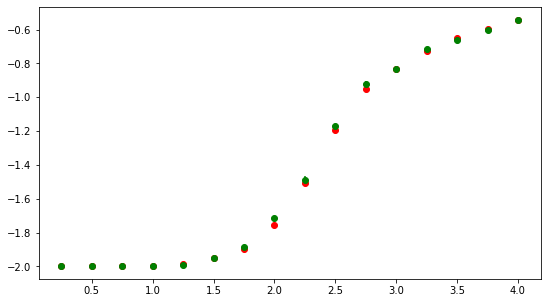

In [ ]:
#plot graph
T = np.linspace(0.25,4,16)


# Energy per N
plt.figure(figsize=(9,5))
plt.errorbar(T,final_mean_dict_sw["Energy per N"],final_sd_dict_sw["Energy per N"],fmt='o',color="red",label="SW-BEF")
plt.errorbar(T,final_mean_dict_sw_HK["Energy per N"],final_sd_dict_sw_HK["Energy per N"],fmt='o',color="green",label="SW-HK")
plt.errorbar(T,final_mean_dict_mc["Energy per N"],final_sd_dict_mc["Energy per N"],fmt='o',color="blue",label="MC")
plt.errorbar(T,final_mean_dict_wolff_BEF["Energy per N"],final_sd_dict_wolff_BEF["Energy per N"],fmt='o',color="grey",label="Wolff-BEF")
plt.title("Energy per N versus temperature when L = {L}".format(L=L))
plt.legend()
plt.show()

# |m|
plt.figure(figsize=(9,5))
plt.errorbar(T,final_mean_dict_sw["Absolute M"],final_sd_dict_sw["Absolute M"],fmt='o',color="red",label="SW-BEF")
plt.errorbar(T,final_mean_dict_sw_HK["Absolute M"],final_sd_dict_sw_HK["Absolute M"],fmt='o',color="green",label="SW-HK")
plt.errorbar(T,final_mean_dict_mc["Absolute M"],final_sd_dict_mc["Absolute M"],fmt='o',color="blue",label="MC")
plt.errorbar(T,final_mean_dict_wolff_BEF["Absolute M"],final_sd_dict_wolff_BEF["Absolute M"],fmt='o',color="grey",label="Wolff-BEF")
plt.title("Magnetization (|m|) versus temperature when L = {L}".format(L=L))
plt.legend()
plt.show()

# specific heat
plt.figure(figsize=(9,5))
plt.errorbar(T,final_mean_dict_sw["specific heat"],final_sd_dict_sw["specific heat"],fmt='o',color="red",label="SW-BEF")
plt.errorbar(T,final_mean_dict_sw_HK["specific heat"],final_sd_dict_sw_HK["specific heat"],fmt='o',color="green",label="SW-HK")
plt.errorbar(T,final_mean_dict_mc["specific heat"],final_sd_dict_mc["specific heat"],fmt='o',color="blue",label="MC")
plt.errorbar(T,final_mean_dict_wolff_BEF["specific heat"],final_sd_dict_wolff_BEF["specific heat"],fmt='o',color="grey",label="Wolff-BEF")
plt.title("Specific heat versus temperature when L = {L}".format(L=L))
plt.legend()
plt.show()


# suspectility
plt.figure(figsize=(9,5))
plt.errorbar(T,final_mean_dict_sw["suspectility"],final_sd_dict_sw["suspectility"],fmt='o',color="red",label="SW-BEF")
plt.errorbar(T,final_mean_dict_sw_HK["suspectility"],final_sd_dict_sw_HK["suspectility"],fmt='o',color="green",label="SW-HK")
plt.errorbar(T,final_mean_dict_mc["suspectility"],final_sd_dict_mc["suspectility"],fmt='o',color="blue",label="MC")
plt.errorbar(T,final_mean_dict_wolff_BEF["suspectility"],final_sd_dict_wolff_BEF["suspectility"],fmt='o',color="grey",label="Wolff")
plt.title("Suspectility versus temperature when L = {L}".format(L=L))
plt.legend()
plt.show()

In [ ]:
# plotting the subplot
L=10

fig, ax = plt.subplots(2,2,figsize=(16,9))


ax[0,0].errorbar(T,final_mean_dict_sw_HK["Energy per N"],final_sd_dict_sw_HK["Energy per N"],fmt='o',color="green",label="SW-HK")
ax[0,0].set_title("Energy per N versus temperature when L = {L}".format(L=L),size=15)
ax[0,0].set_ylabel("Energy per N",fontsize=10)
ax[0,0].set_xlabel("Temperature",fontsize=10)

ax[0,1].errorbar(T,final_mean_dict_sw_HK["Absolute M"],final_sd_dict_sw_HK["Absolute M"],fmt='o',color="green",label="SW-HK")
ax[0,1].set_title("<|m|> versus temperature when L = {L}".format(L=L),size=15)
ax[0,1].set_ylabel("<|m|>",fontsize=10)
ax[0,1].set_xlabel("Temperature",fontsize=10)


ax[1,0].errorbar(T,final_mean_dict_sw_HK["specific heat"],final_sd_dict_sw_HK["specific heat"],fmt='o',color="green",label="SW-HK")
ax[1,0].set_title("Specific heat versus temperature when L = {L}".format(L=L),size=15)
ax[1,0].set_ylabel("Specific heat",fontsize=10)
ax[1,0].set_xlabel("Temperature",fontsize=10)

ax[1,1].errorbar(T,final_mean_dict_sw_HK["suspectility"],final_sd_dict_sw_HK["suspectility"],fmt='o',color="green",label="SW-HK")
ax[1,1].set_title("Suspectility versus temperature when L = {L}".format(L=L),size=15)
ax[1,1].set_ylabel("Suspectility",fontsize=10)
ax[1,1].set_xlabel("Temperature",fontsize=10)

fig.tight_layout(h_pad=3) # adjust the sapce between each subplot

In [ ]:
#For get the MC steps for thermalization

def sw_test_return(Temperature,iteration,L):
  Energy_list = []
  lattice_dict = gen_lattice_2D_square_lattice(L)

  for i in range(iteration):
    lattice_dict = SW_algo_step_square(lattice_dict,Temperature,L)
    Energy_list.append(Energy(lattice_dict,L))

  return Energy_list

iteration = 10000
temperature = 0.5
L = 32
plt.figure(figsize=(20,9))
Energy_list =  sw_test_return(temperature,iteration,L)

plt.plot([i for i in range(0,iteration)],[i/L**2 for i in Energy_list])

plt.xlabel("Number of iterations")
plt.ylabel("Energy per N")
plt.title("Energy per N vs number of iterations")
plt.show()

## 5. Autocorrelation

In [ ]:
def computeAutocorrelation(Q_list,tau_num,knum):
    A_list_tau = []
    A_std_tau = []

    for tau in range(tau_num):
        product = []
        Q_list_k = []
        Q_list_k_square = []
        A_bin_k = []

        for k in range(knum-tau):
            product.append(Q_list[k]*Q_list[k+tau])
            Q_list_k.append(Q_list[k])
            Q_list_k_square.append(Q_list[k]**2)

            # Divide (knum-tau) into 10 groups, take average of each group
            if k%(knum/10) == 0 and k !=0:
                # Book P.101
                A_list_k = (np.mean(product)-np.mean(Q_list_k)**2)/(np.mean(Q_list_k_square)-np.mean(Q_list_k)**2)

                # A_bin_k should finally contains knum - tau elements
                A_bin_k.append(A_list_k)

                # clear the temporary list
                product=[]
                Q_list_k=[]
                Q_list_k_square=[]

        A_list_tau.append(np.mean(A_bin_k))
        A_std_tau.append(np.std(A_bin_k))

        if A_list_tau[-1] <=0.01:
            A_list_tau.extend([np.nan]*(tau_num-len(A_list_tau)))
            A_std_tau.extend([np.nan]*(tau_num-len(A_std_tau)))
            break

    return A_list_tau, A_std_tau

In [ ]:
"""
correlation_cal

Description
This is the main function of this part

Parameters
----------
1. algo - the name of algo using
2. tau_num
3. MC_steps
4. size_lists
5. T_c = 2.269
-------

Return
----------
1. expect_dict,sd_dict  - similar to MC algo

-------
"""

def correlation_cal(algo, tau_num, MC_steps,size_list,T_c=2.269,name_of_algo="Default"): # Q1

    # change to a larger value later
    thermalization_steps = 2000
    A_M_abs_L=[]
    A_M_abs_std_L=[]

    #autocorrelation_A_abs_m_dict = dict()
    for L in size_list:
        lattice = gen_lattice_2D_square_lattice(L)

        #1. Thermalization
        for i in range(thermalization_steps):
            # change to new_lattice_dict later
            lattice = algo(lattice,T_c,L)
        print("Finish thermalization at L = {L}".format(L=L))

        #2. Collect |m|
        m_abs_list = []
        for i in range(MC_steps):
            lattice = algo(lattice,T_c,L)
            m_abs_list.append(M(lattice,L)) # Should I change this line to m_not_absolute(lattice_dict,L)  No
        print("Finish collecting |m| at L = {L}".format(L=L))

        m_abs_list=np.array(m_abs_list)
        np.save(f"Autocorrelation_{name_of_algo}_{L}_{MC_steps}.npy",m_abs_list)
        print("Finish saving |m| at L = {L}".format(L=L))

        #3. Compute autocorrelation
        A_M_abs_tau, A_M_abs_std_tau = computeAutocorrelation(m_abs_list,tau_num,MC_steps)
        A_M_abs_L.append(A_M_abs_tau)
        A_M_abs_std_L.append(A_M_abs_std_tau)

        A_M_abs_L=np.array(A_M_abs_L)
        A_M_abs_std_L=np.array(A_M_abs_std_L)

        np.save(f"Autocorrelation_{name_of_algo}_{L}_{MC_steps}_A_M_abs_L.npy",A_M_abs_L)
        np.save(f"Autocorrelation_{name_of_algo}_{L}_{MC_steps}_A_M_abs_std_L.npy",A_M_abs_std_L)

        print("Finish saving A_M_abs_L & A_M_abs_std_L at L = {L}".format(L=L))

    return A_M_abs_L, A_M_abs_std_L

In [ ]:
# SW algorithm

"""

size_list=[20,24,28,32]
tau_num=250
MC_steps=100000

A_M_abs_L_sw, A_M_abs_std_L_sw = correlation_cal(
    algo = SW_algo_step_square,
    tau_num=tau_num,
    MC_steps=MC_steps,
    size_list=size_list,
    T_c=2.269,
    name_of_algo = "SW"
    )


# Wolff algorithm
size_list=[32]
tau_num=250
MC_steps=300000
A_M_abs_L_wolff, A_M_abs_std_L_wolff = correlation_cal(
    algo = wolff_step_square_BEF,
    tau_num=tau_num,
    MC_steps=MC_steps,
    size_list=size_list,
    T_c=2.269,
    name_of_algo = "Wolff"
    )

"""

# Metropolis algorithm

size_list=[20]
tau_num=200
MC_steps=300000

A_M_abs_L_metro, A_M_abs_std_L_metro = correlation_cal(
    algo = MC_step_square,
    tau_num=tau_num,
    MC_steps=MC_steps,
    size_list=size_list,
    T_c=2.269,
    name_of_algo = "Metro"
    )

Finish thermalization at L = 20
Finish collecting |m| at L = 20
Finish saving |m| at L = 20
Finish saving A_M_abs_L & A_M_abs_std_L at L = 20


In [ ]:
"""
# Load the stored data - Wolff
tau_num = 250
size_list = [20,24,28,32]
A_M_abs_L_wolff = []
A_M_abs_std_L_wolff = []

for L in size_list:
    name_of_file_mean = f"Autocorrelation_Wolff_{L}_300000_A_M_abs_L.npy"
    name_of_file_sd = f"Autocorrelation_Wolff_{L}_300000_A_M_abs_std_L.npy"

    A_M_abs_L_wolff.append(np.load(name_of_file_mean)[0])
    A_M_abs_std_L_wolff.append(np.load(name_of_file_sd)[0])
"""

In [ ]:
# Load the stored data - Metro
tau_num = 200
size_list = [20,24,28]
A_M_abs_L_metro = []
A_M_abs_std_L_metro = []


for L in size_list:

    name_of_file_mean = f"C:/Users/timch/OneDrive - connect.hku.hk/University life/All the coding stuff (Onedrive)/SRF/data/For autocorrelation calculation/Metropolis/Autocorrelation_Metro_{L}_300000_A_M_abs_L.npy"
    name_of_file_sd = f"C:/Users/timch/OneDrive - connect.hku.hk/University life/All the coding stuff (Onedrive)/SRF/data/For autocorrelation calculation/Metropolis/Autocorrelation_Metro_{L}_300000_A_M_abs_std_L.npy"

    A_M_abs_L_metro.append(np.load(name_of_file_mean)[0])
    A_M_abs_std_L_metro.append(np.load(name_of_file_sd)[0])


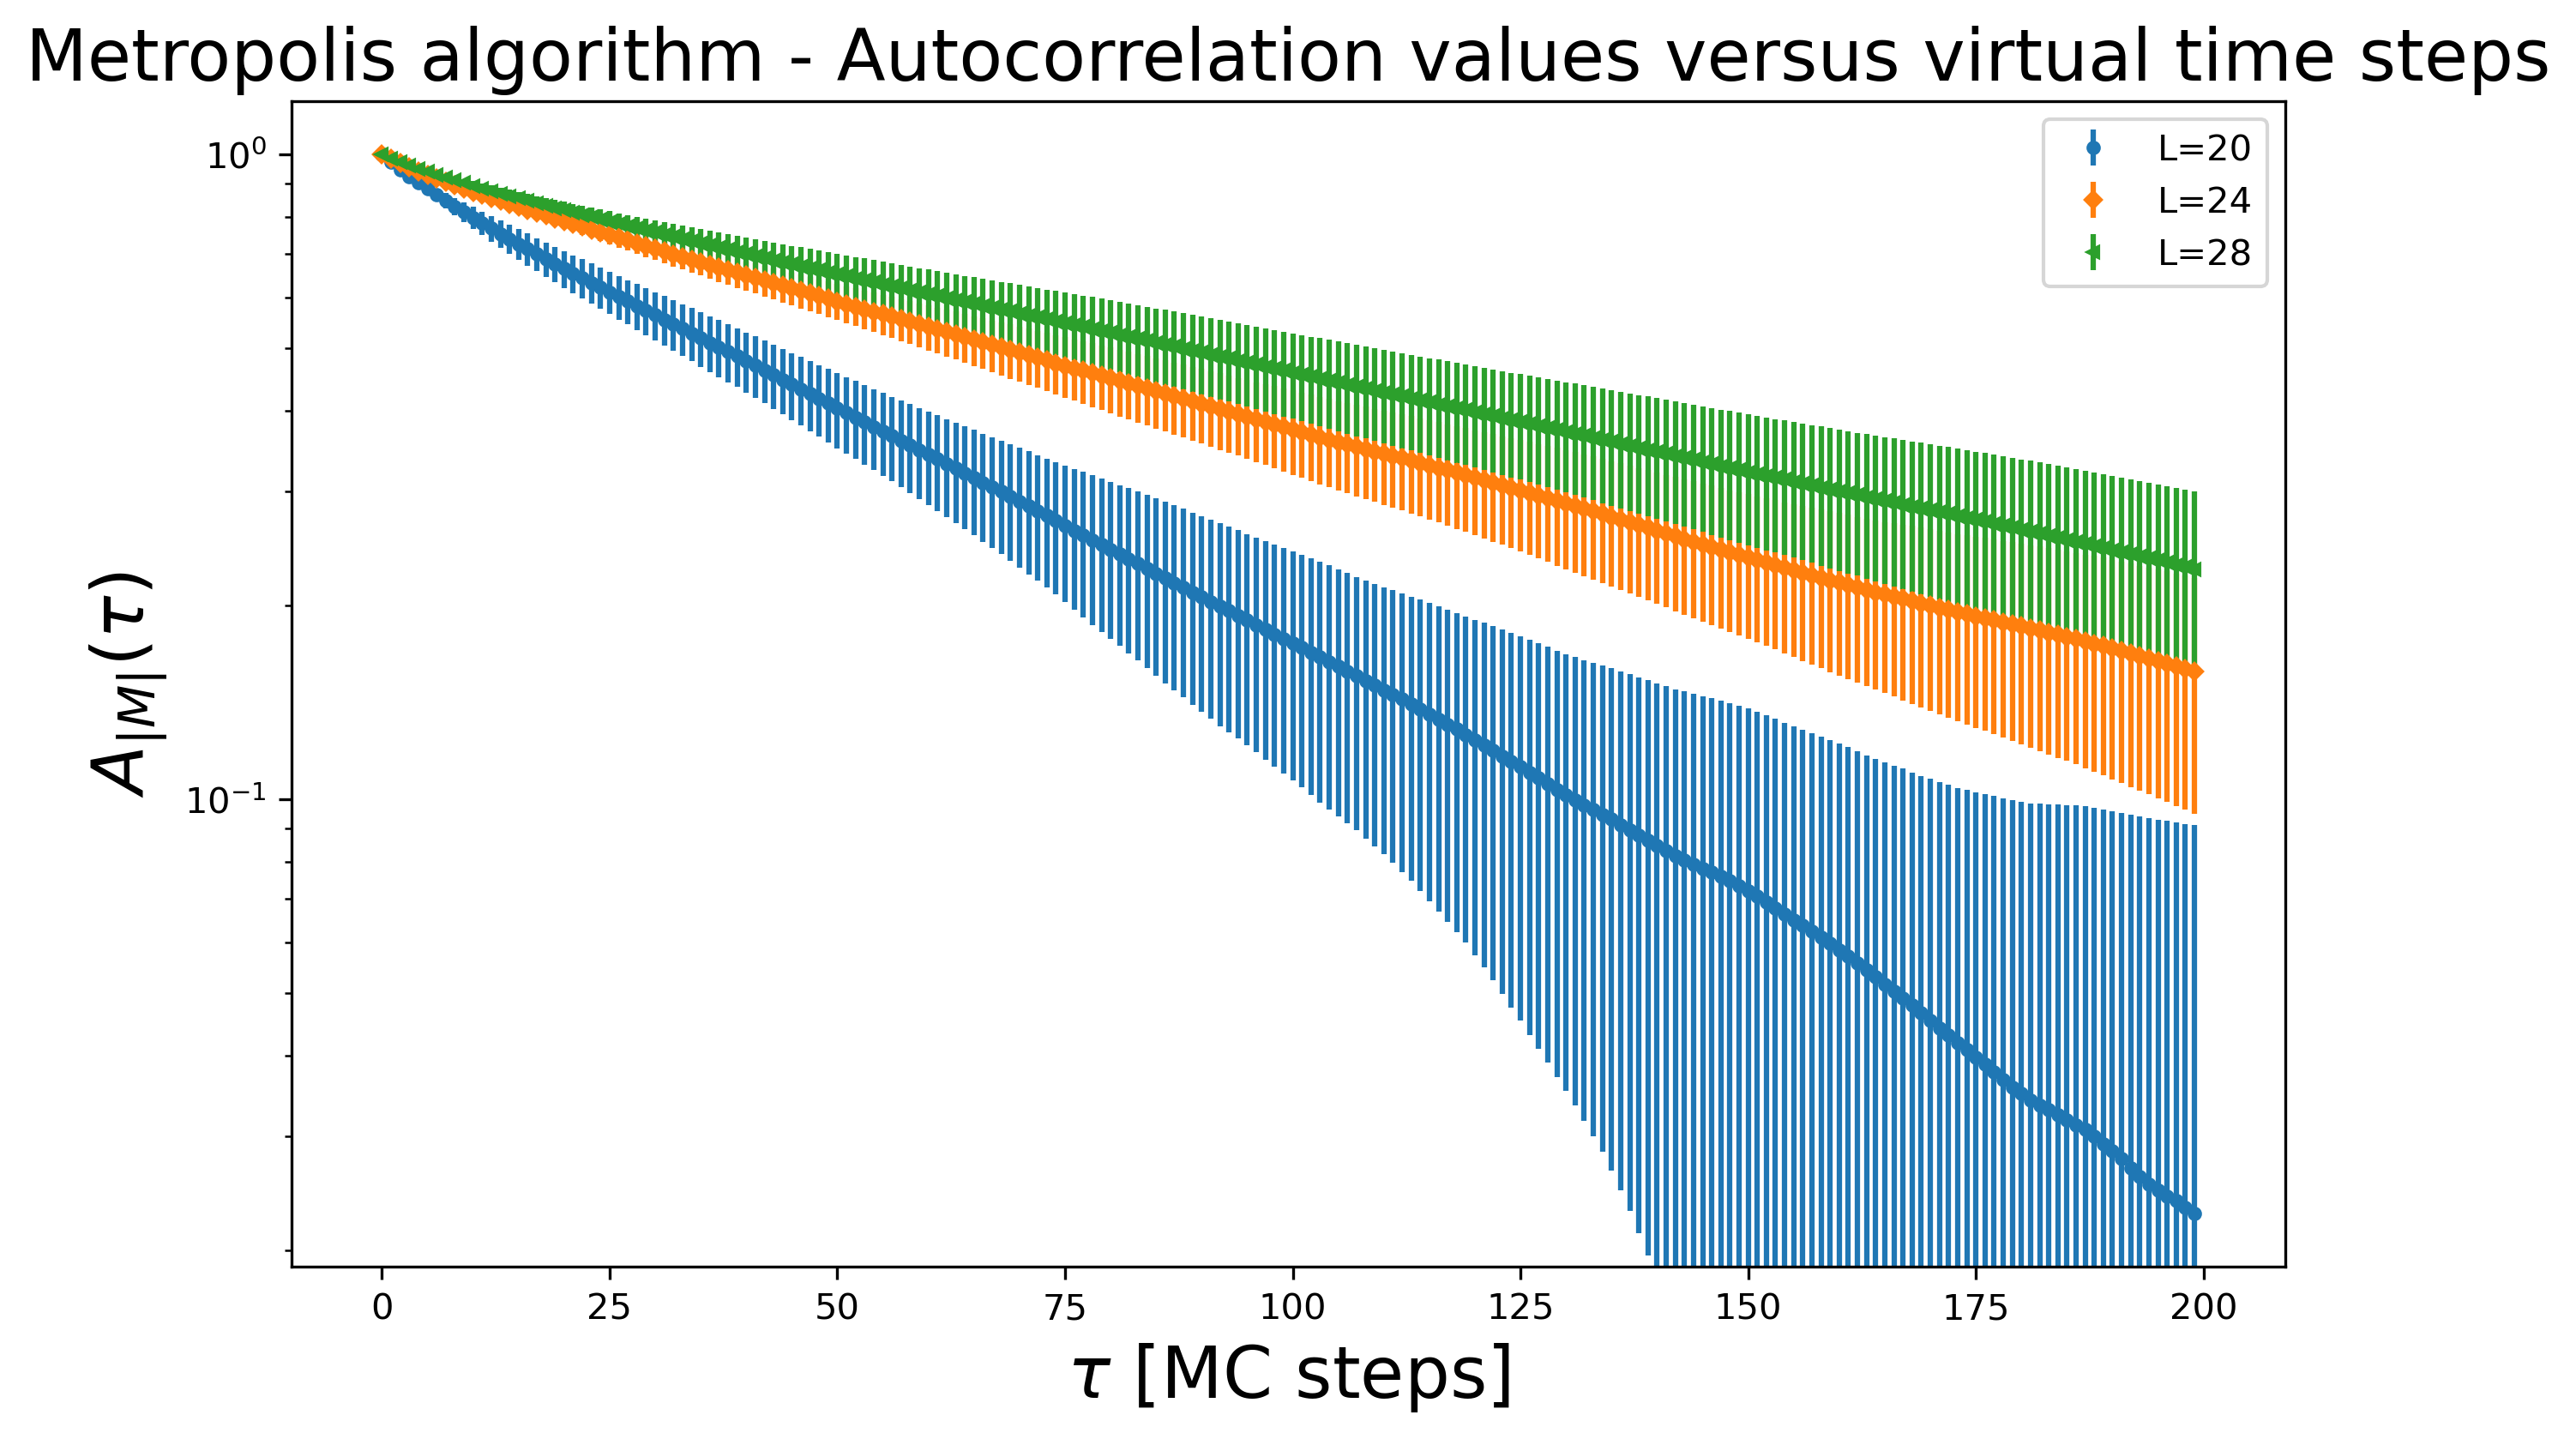

In [ ]:
# Plot graph - Metropolis algorithm

plt.figure(figsize=(10,6), dpi=300)
markers = ["o","D","<","p",">","v","*","^"]
for i in range(len(size_list)):
    plt.errorbar(list(range(tau_num)), A_M_abs_L_metro[i],A_M_abs_std_L_metro[i], fmt=markers[i], markersize=3,label="L="+str(size_list[i]))
plt.title("Metropolis algorithm - Autocorrelation values versus virtual time steps",fontsize=20)
plt.xlabel(r"$\tau$ [MC steps]", fontsize=20)
plt.ylabel(r"$A_{|M|}(\tau)$", fontsize=20)
plt.yscale("log")
plt.legend()
plt.savefig(f"Metropolis algorithm {size_list} versus steps")

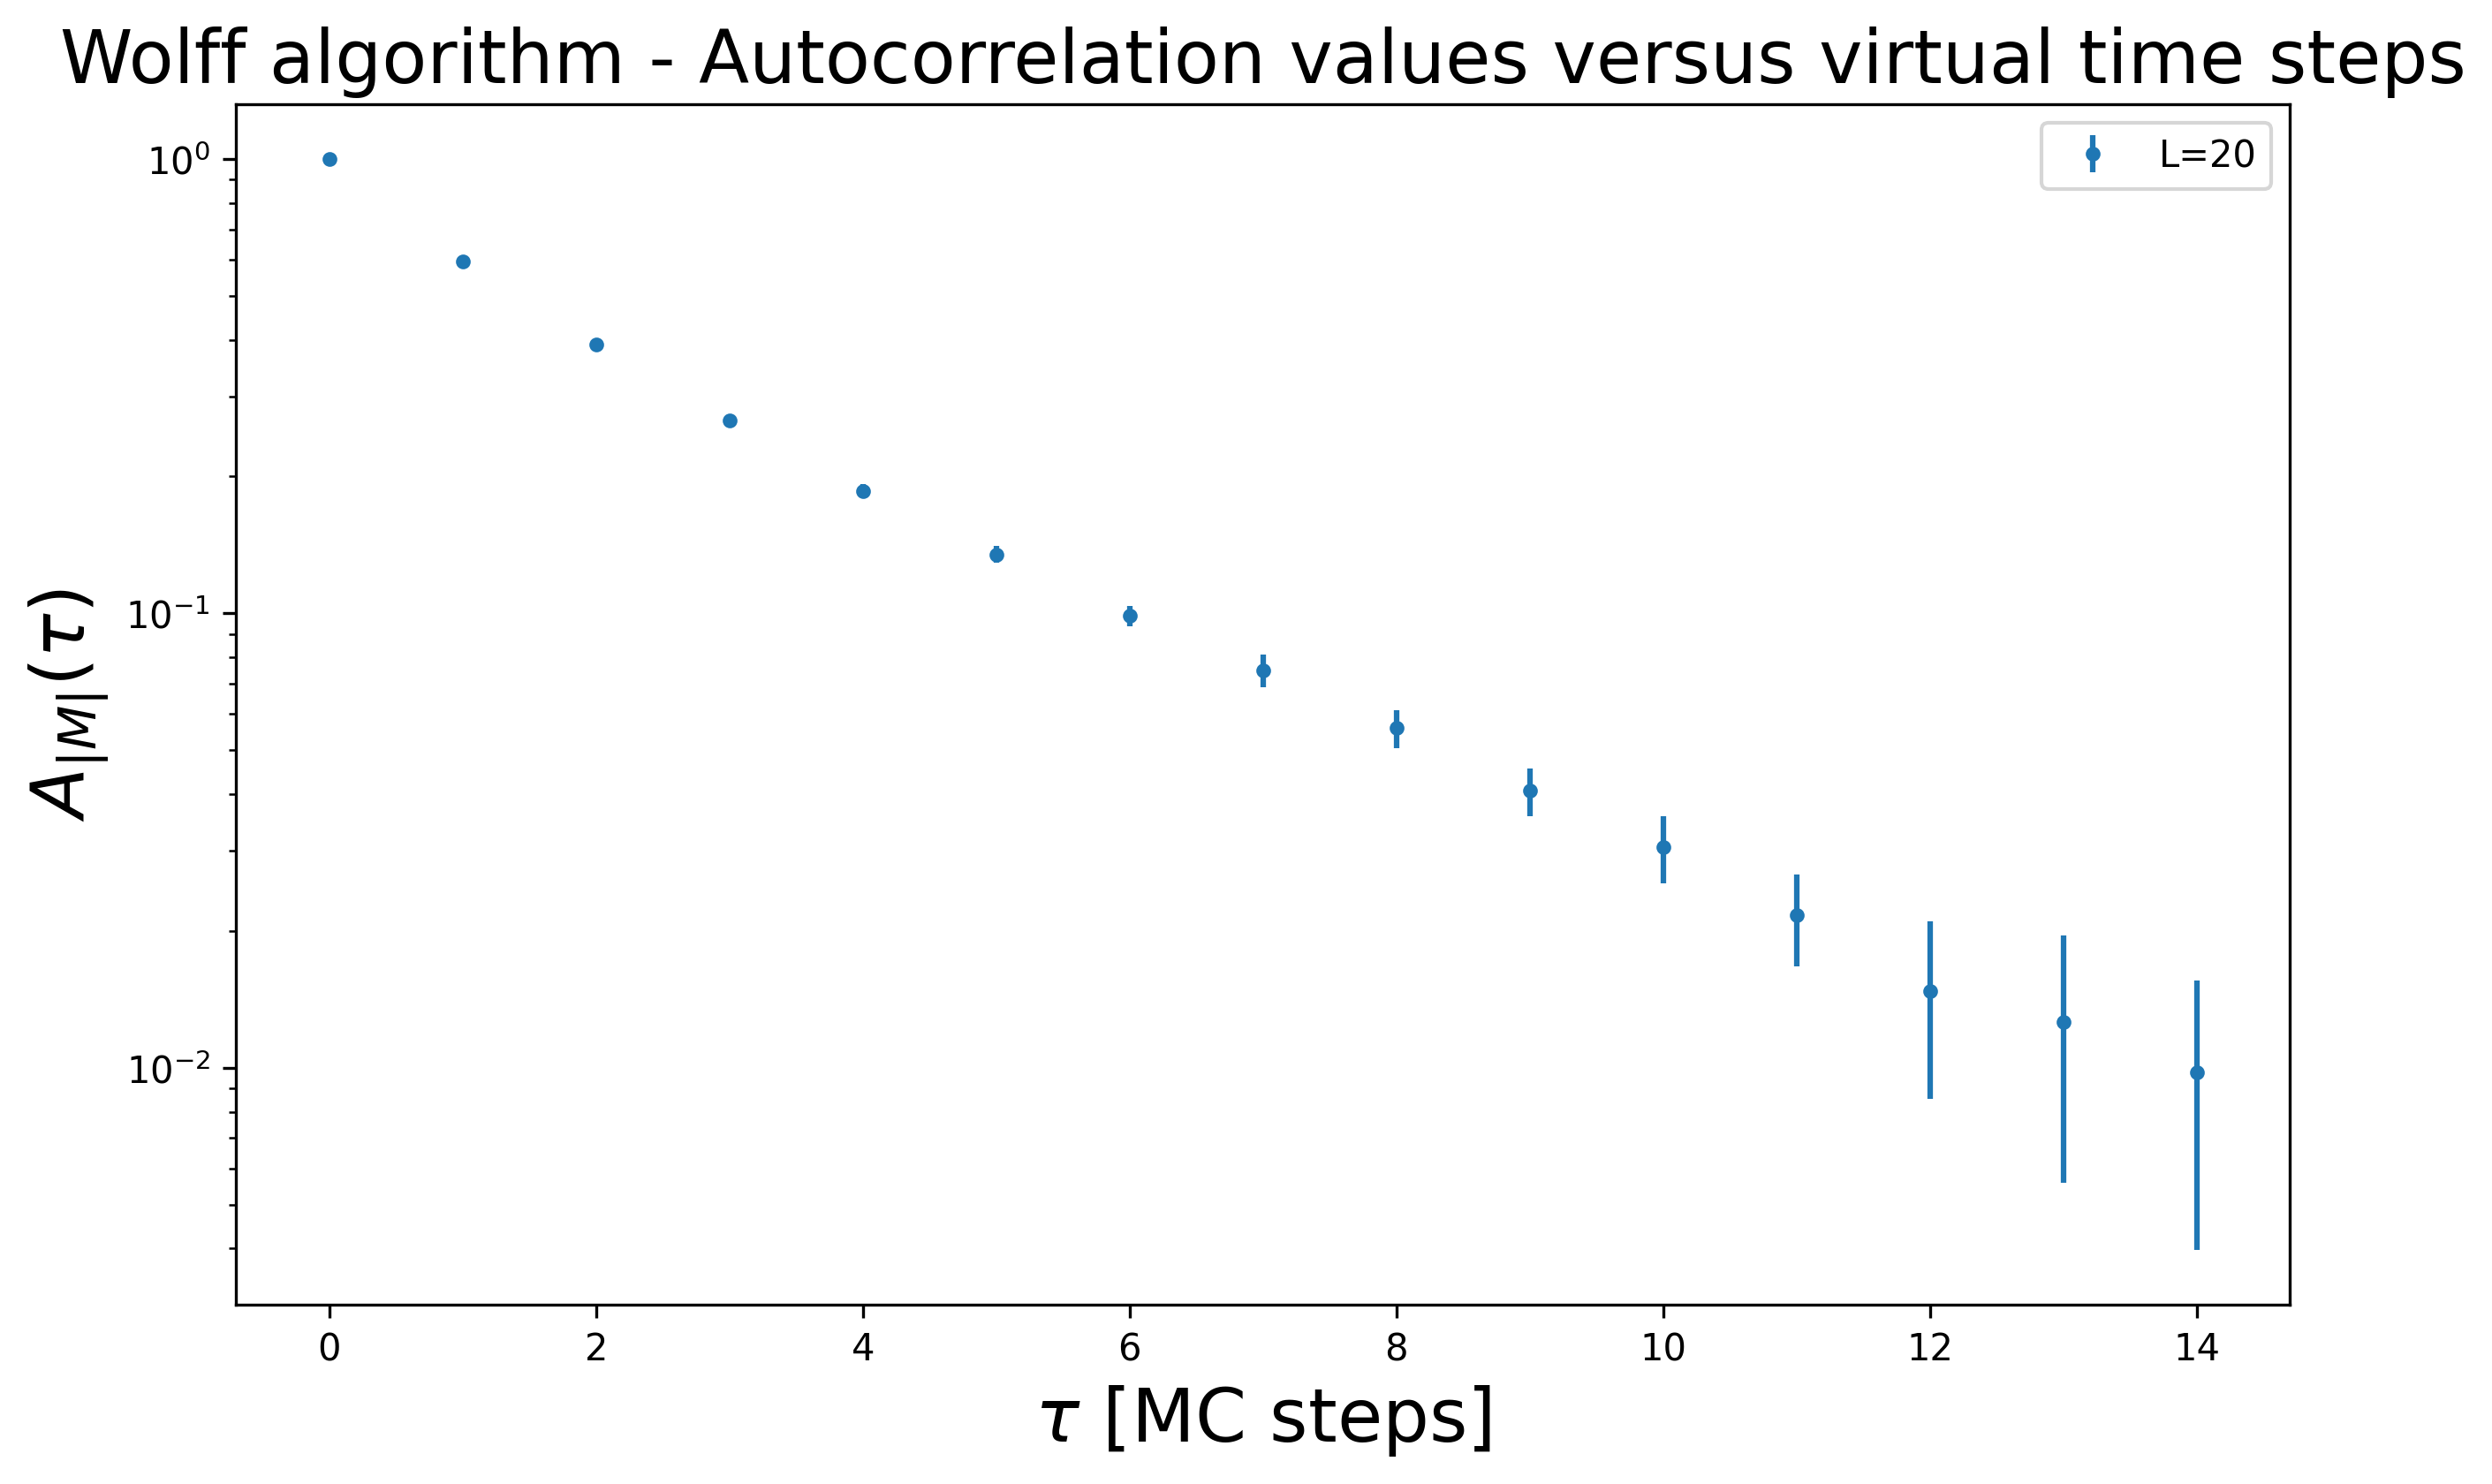

In [ ]:
# Plot graph - Wolff algorithm

plt.figure(figsize=(10,6), dpi=300)
markers = ["o","D","<","p",">","v","*","^"]
for i in range(len(size_list)):
    plt.errorbar(list(range(tau_num)), A_M_abs_L_wolff[i],A_M_abs_std_L_wolff[i], fmt=markers[i], markersize=3,label="L="+str(size_list[i]))
plt.title("Wolff algorithm - Autocorrelation values versus virtual time steps",fontsize=20)
plt.xlabel(r"$\tau$ [MC steps]", fontsize=20)
plt.ylabel(r"$A_{|M|}(\tau)$", fontsize=20)
plt.yscale("log")
plt.legend()
plt.savefig(f"Wolff algorithm {size_list} versus steps")

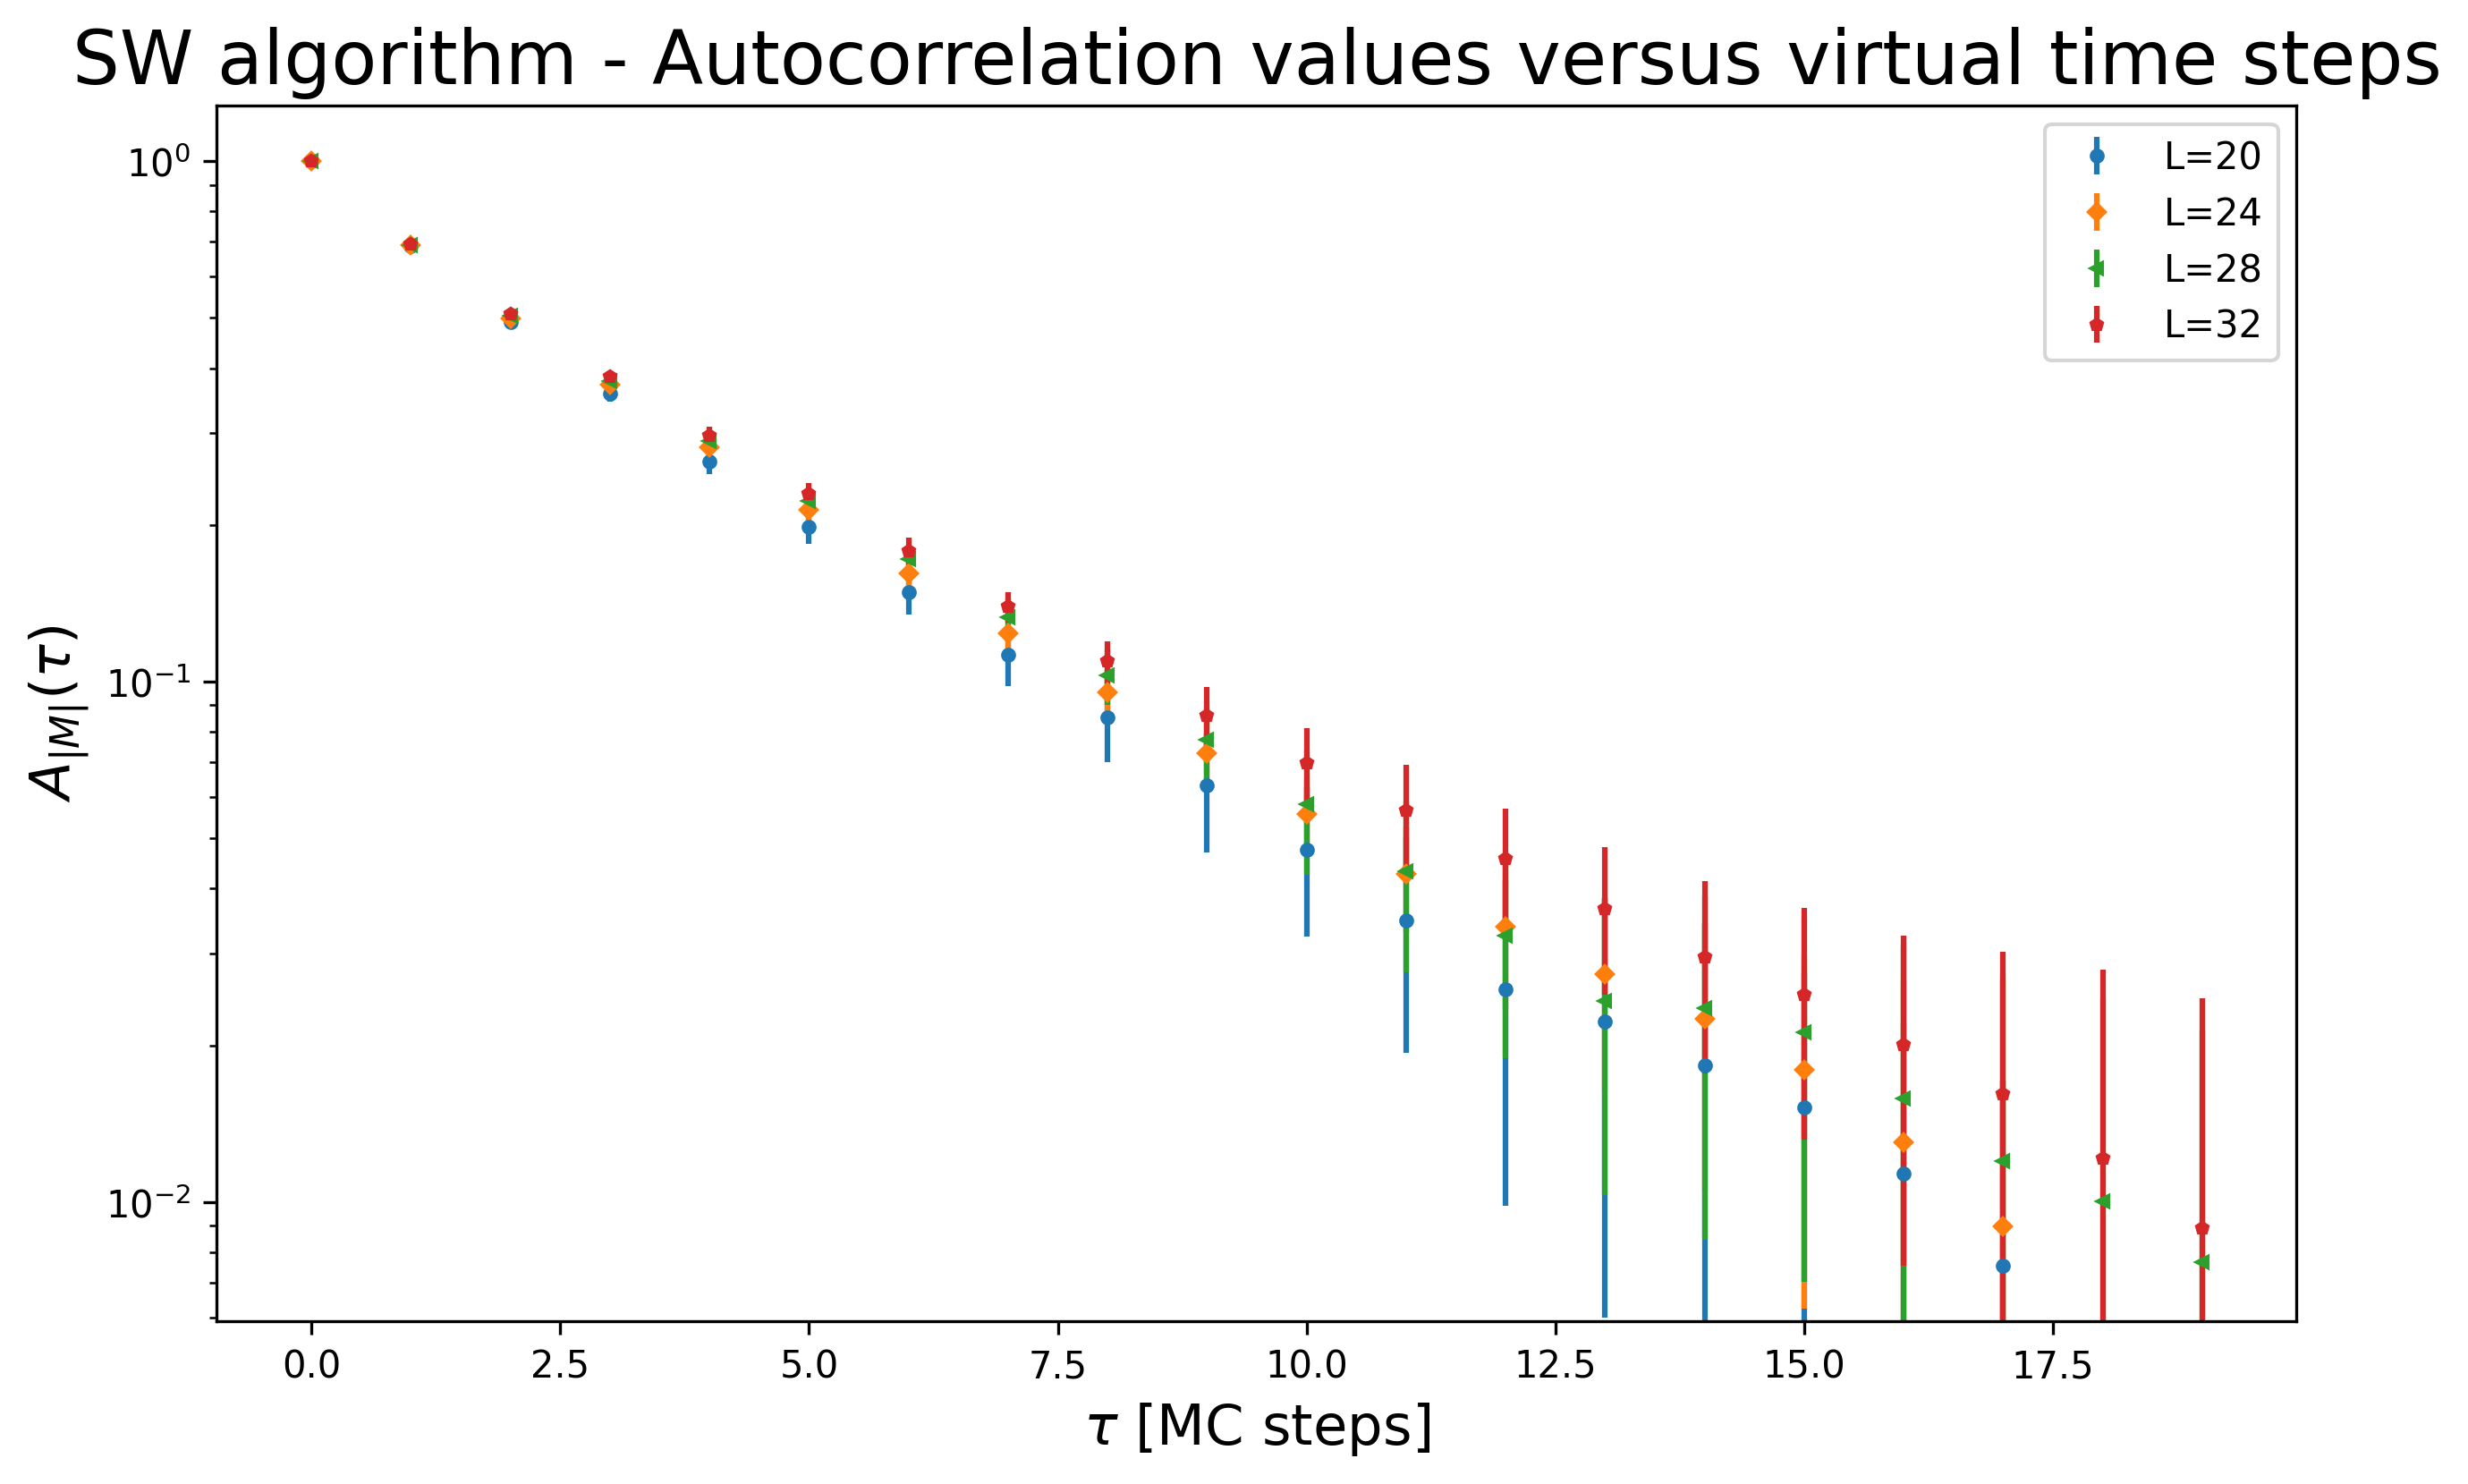

In [ ]:
# Plot graph - SW algorithm

plt.figure(figsize=(10,6), dpi=300)
markers = ["o","D","<","p",">","v","*","^"]
for i in range(len(size_list)):
    plt.errorbar(list(range(tau_num)), A_M_abs_L_sw[i],A_M_abs_std_L_sw[i], fmt=markers[i], markersize=3,label="L="+str(size_list[i]))
plt.xlabel(r"$\tau$ [MC steps]", fontsize=15)
plt.ylabel(r"$A_{|M|}(\tau)$", fontsize=15)
plt.yscale("log")
plt.legend()
plt.title("SW algorithm - Autocorrelation values versus virtual time steps",fontsize=20)
#plt.savefig(f"SW algorithm {size_list} versus steps")

In [ ]:
def fitting_straight_line(x,y):
    from sklearn import linear_model
    regr = linear_model.LinearRegression()
    X =  np.array(x).reshape(-1, 1)
    Y = np.array(y).reshape(-1, 1)
    regr.fit(X, Y)

    return regr.coef_, regr.intercept_

In [ ]:
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a*np.power(x, b)

def AutocorrelationTime(A_M_abs_L,size_list):

    autocorr_time_list=[]
    AL_log_list=[]

    A_M_abs_L=np.array(A_M_abs_L)

    for i in range(len(A_M_abs_L)):
        AL=np.array(A_M_abs_L[i])
        AL_log = np.log(AL[AL>0])[:95:]
        AL_log_list.append(AL_log)
        autocorr_time = -1/(fitting_straight_line(np.arange(len(AL_log)),AL_log)[0][0]) #Important
        autocorr_time_list.append(autocorr_time)

    autocorr_time_list = np.array(autocorr_time_list).reshape(1,-1)[0]

    pars = curve_fit(power_law, size_list, autocorr_time_list, p0=[0, 1])[0]

    return autocorr_time_list,pars

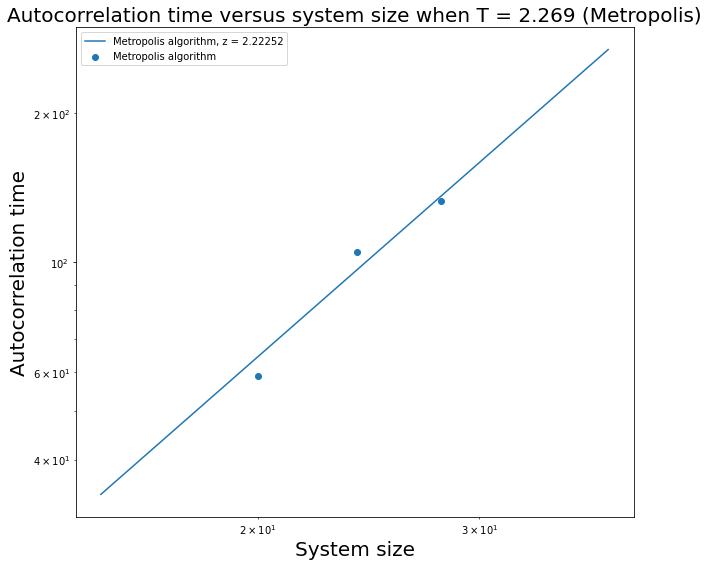

In [ ]:
temp_test1,pars_test1 = AutocorrelationTime(A_M_abs_L_metro,size_list)
intercept_sw_test1 = pars_test1[0]
slope_sw_test1 = pars_test1[1]

L = np.linspace(size_list[0]-5,size_list[-1]+10,1000)

plt.figure(figsize=(10,9))
plt.title("Autocorrelation time versus system size when T = 2.269 (Metropolis)",fontsize=20)
plt.scatter(size_list, temp_test1,label="Metropolis algorithm")
plt.plot(L,power_law(L,intercept_sw_test1,slope_sw_test1), label="Metropolis algorithm, z = {slope}".format(slope = np.round(slope_sw_test1,5)))
plt.legend()
plt.xlabel("System size",fontsize=20)
plt.ylabel("Autocorrelation time",fontsize=20)
plt.yscale("log")
plt.xscale("log")
plt.savefig("autocorrelation_time_versus_system_size_when_T=T_c (Metropolis)(final).jpg")


The linear dynamic critical exponents of
- Metropolis algorithm (z = 2.215)
- Wolff algorithm (z = 0.25)
- Swendsen Wang algorithm (z = 0.35)

## 6. Finite size scaling and Binder Ratio/ Binder Cumulant

- In the following section, I would focus on the temperature ranging from 2 to 3.
- Some useful constant (from Onsager's solution),
  - $\nu_{2D} = 1$
  - $\eta_{2D} = \frac{1}{4}$
  - $\beta_{2D} = \frac{1}{8}$
  - $\omega_{2D} = 2$

- Binder Cumulant
  - $U_L(T) = 1 - \frac{<m^4>_{L}}{3<m^2>^2_L}$

- Binder Ratio
  - $B_Q = \frac{\langle m^2 \rangle}{\langle |m| \rangle^2}$ or $B_Q = \frac{\langle m^4 \rangle}{\langle m^2 \rangle^2}$

I will be using **Wolff Algorithm** to do the simulation in the following session.

### Calculation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
"""
wolff_algo_at_T_simp

This function perform the same function as wolff_algo_at_T. But it only calculates <|m|>, <m^2>, <"suspectility">,
Binder Ratio and Binder Cumulant.

Parameters
----------
1. Temperature
2. Iteration
3. L
-------

Return
----------
1. expect_dict,sd_dict  - similar to MC algo

-------
"""
def wolff_algo_at_T_simp(Temperature,iteration,L):

#1. Generate equilibrium lattice
  lattice_dict = gen_lattice_2D_square_lattice(L)
  for i in range(2000):
    lattice_dict = wolff_step_square_BEF(lattice_dict,Temperature,L)

  #print("Finish in generating equilibrium lattice")
#2. Keep on running,collect data
  expect_dict = {"Absolute M":[],"m^2":[],"suspectility":[],"Binder_ratio":[],"Binder_Cumulant":[]}
  sd_dict = {"Absolute M":[],"m^2":[],"suspectility":[],"Binder_ratio":[],"Binder_Cumulant":[]}
  temp_dict={"Absolute M":[],"m^2":[],"m^4":[],"Binder_ratio":[],"Binder_Cumulant":[]}

  for i in range(iteration):
    lattice_dict = wolff_step_square_BEF(lattice_dict,Temperature,L)
    temp_dict["Absolute M"].append(M(lattice_dict,L))
    temp_dict["m^2"].append(m_square(lattice_dict,L))
    #m_power_4(lattice_dict,L):
    temp_dict["m^4"].append(m_power_4(lattice_dict,L))

    if i%100==0 and i!=0:
      expect_dict["suspectility"].append(susceptibility(L,Temperature,temp_dict["Absolute M"]))
      expect_dict["Absolute M"].append(np.mean(temp_dict["Absolute M"]))
      expect_dict["m^2"].append(np.mean(temp_dict["m^2"]))

      m_power_4_array = np.mean(temp_dict["m^4"])
      m_power_2_array = np.mean(temp_dict["m^2"])

      binder_ratio = m_power_4_array/(m_power_2_array)**2
      binder_cumulant = 3/2 * (1 - 1/3 * binder_ratio)

      expect_dict["Binder_ratio"].append(binder_ratio)
      expect_dict["Binder_Cumulant"].append(binder_cumulant)

      #clear the dictionary
      temp_dict.fromkeys(temp_dict,[])

  ## Take mean
  for i in expect_dict.keys():
    sd_dict[i] = np.std(expect_dict[i])
    expect_dict[i] = np.mean(expect_dict[i])

  print("Complete collecting data at temperature = {T}".format(T=Temperature))

  return expect_dict,sd_dict


In [ ]:
# Calculate the data again

"""
- The following flipping will be done using SW algorithm
- This part will also calculate the result for Binder ratio

total_expect_dict has the following structure,
{size:{"Absolute M":[],"m^2":[],"suspectility":[],"Binder_ratio":[]}, size_2: ...}

total_std_dict is similar


"""

size_list = [8,16,32]
iteration = 8000

total_expect_dict = dict()
total_std_dict = dict()

T = np.linspace(2,3,25)

for L in size_list:
    temp_dict_at_L = {"Absolute M":[],"m^2":[],"suspectility":[],"Binder_ratio":[],"Binder_Cumulant":[]}
    temp_std_dict_at_L  = {"Absolute M":[],"m^2":[],"suspectility":[],"Binder_ratio":[],"Binder_Cumulant":[]}
    print("Start doing L = {l}".format(l=L))

    for i in range(len(T)):
        expect_dict, sd_dict = wolff_algo_at_T_simp(T[i],iteration,L)

        for i in expect_dict.keys():
            temp_dict_at_L[i].append(float(expect_dict[i]))
            temp_std_dict_at_L[i].append(float(sd_dict[i]))

    total_expect_dict[L] = temp_dict_at_L
    total_std_dict[L] = temp_std_dict_at_L

In [ ]:
T = np.linspace(2,3,25)
size_list = [8,16,32]
total_expect_dict = {8: {'Absolute M': [0.9135894422164341, 0.8943008487068792, 0.8811721955201584, 0.8607778408443393, 0.8355080282153519, 0.821850466715589, 0.792195970801332, 0.7444467900237596, 0.7267649042755141, 0.6978977045682133, 0.6685756513893253, 0.6491197623405451, 0.5962407792893151, 0.5719780492708324, 0.5339510247572214, 0.5302123618062815, 0.49301858445788177, 0.4620756945822671, 0.42969249050413577, 0.42292770406003133, 0.40661130896473724, 0.3881333276489033, 0.3774634962459919, 0.35119499564177864, 0.3495693283520479], 'm^2': [0.8446098487476484, 0.8147913148434442, 0.7933450444070455, 0.7640521281937788, 0.7262129558340193, 0.7054721824381668, 0.6652815197672579, 0.6029573165726502, 0.5816599391352244, 0.5462723520715532, 0.509514506955562, 0.48502033449291126, 0.4245569189587019, 0.39681055261218207, 0.35689947213904993, 0.35004243277679464, 0.3153383941961453, 0.27990208864441896, 0.24923205517754396, 0.2427938697361694, 0.22485274444104392, 0.20777812666334533, 0.19900084517960745, 0.17818063504182632, 0.1722922983200686], 'suspectility': [0.31875640479518347, 0.4704720959233962, 0.5183811010793181, 0.6951682564663304, 0.8294701054564446, 0.8691240860966813, 1.071801250564926, 1.3579312231189953, 1.4660587948137642, 1.5929608524906922, 1.6551856280583856, 1.655773203587718, 1.7619803422411984, 1.7531093838636351, 1.7768561707984798, 1.6726885722607234, 1.7315443946500688, 1.5677316696975319, 1.499687091921188, 1.4642463668644359, 1.3406242440496283, 1.2697314847253687, 1.239653910744928, 1.1847666641668217, 1.0682291537511073], 'Binder_ratio': [1.0341156353451606, 1.0484939796381947, 1.0574537734564349, 1.0753907383552077, 1.0948488532575265, 1.1095279850862347, 1.141556672515409, 1.202153200093557, 1.224647712440923, 1.2691024390942214, 1.311001441138531, 1.3420471152850093, 1.4403096389443397, 1.498107264259031, 1.5832032653754058, 1.577446062233725, 1.7083884166279113, 1.75911135669606, 1.8761024535233766, 1.8901331444519127, 1.942143619516885, 1.9923612092123766, 2.0349715261906938, 2.1934316574901507, 2.109501654045219], 'Binder_Cumulant': [0.98294218232742, 0.9757530101809027, 0.9712731132717827, 0.962304630822396, 0.9525755733712366, 0.9452360074568827, 0.9292216637422956, 0.8989233999532215, 0.8876761437795385, 0.8654487804528895, 0.8444992794307347, 0.8289764423574953, 0.7798451805278301, 0.7509463678704846, 0.7083983673122972, 0.7112769688831375, 0.6458057916860449, 0.6204443216519699, 0.5619487732383116, 0.5549334277740439, 0.5289281902415575, 0.5038193953938116, 0.48251423690465306, 0.4032841712549246, 0.4452491729773902]}, 16: {'Absolute M': [0.9092516853284525, 0.894184050079578, 0.8748685279562021, 0.8556387643663326, 0.8241021557984121, 0.7844842121618141, 0.7369206471048333, 0.6764121966676052, 0.6287884288128193, 0.5547058232367182, 0.4990862763152654, 0.4268257548459342, 0.39593713839611566, 0.349244466081488, 0.3195090449198947, 0.2901765852206718, 0.2770000903019594, 0.25119392199203, 0.23512545029751547, 0.21963958081409826, 0.20203164775398705, 0.19740953823602805, 0.1777095518349529, 0.1736924612395058, 0.17986544425674278], 'm^2': [0.8298905413456568, 0.8038897840726646, 0.7723969085477955, 0.7405085698130603, 0.6947458025553168, 0.6380516618632909, 0.5731675938625475, 0.5014186724057753, 0.4437701247013262, 0.36329514344509867, 0.3053214577484864, 0.2365129079254863, 0.20865392655579298, 0.16826693945816612, 0.1424470072822343, 0.12115724143231389, 0.10955478376717354, 0.09227778711318307, 0.08217960793003322, 0.07234386968352848, 0.06134465548754592, 0.059810336962741247, 0.04867269899553431, 0.046431985253230564, 0.04851004158409689], 'suspectility': [0.40334193372252647, 0.5418850364456661, 0.8596763622548462, 1.0105167562334734, 1.8397345411465187, 2.6213140388630256, 3.423159681303157, 4.895755167578991, 5.295104698885512, 5.981058339346857, 5.947397394210951, 5.654077480096604, 5.303366653862863, 4.655413678798647, 3.997205572907883, 3.6014723491897263, 3.1412207000956065, 2.7557174082908102, 2.502891912264416, 2.208017053949298, 1.852910122411927, 1.8541283326750224, 1.4993530486198168, 1.3984662090705215, 1.3739759616823652], 'Binder_ratio': [1.0132411954502942, 1.018150718566935, 1.0281676618629911, 1.0346216953835792, 1.0593694707389807, 1.0899599819454533, 1.1350301904573374, 1.2177316317249638, 1.2844530194679515, 1.4129197903946509, 1.5362241262570397, 1.7433138819022431, 1.8331936549484824, 1.991567626677134, 2.0737608475418, 2.258096122649466, 2.206862110565184, 2.3788242058582614, 2.4575635495906005, 2.559643926899755, 2.566221429945882, 2.6302135895285903, 2.7752755940084612, 2.740141870509792, 2.6527547722793905], 'Binder_Cumulant': [0.9933794022748531, 0.9909246407165325, 0.9859161690685044, 0.9826891523082102, 0.9703152646305097, 0.9550200090272729, 0.9324849047713315, 0.891134184137518, 0.8577734902660242, 0.7935401048026747, 0.7318879368714801, 0.6283430590488785, 0.5834031725257591, 0.5042161866614332, 0.46311957622909994, 0.370951938675267, 0.39656894471740817, 0.3105878970708692, 0.2712182252047001, 0.2201780365501225, 0.2168892850270591, 0.18489320523570474, 0.1123622029957697, 0.12992906474510396, 0.1736226138603046]}, 32: {'Absolute M': [0.9109694026986119, 0.895942861112957, 0.8787921808668259, 0.8523691360354688, 0.8218403602725414, 0.7675302487231254, 0.6971115541335855, 0.6060394446589061, 0.4695400770774171, 0.36873345958910075, 0.2820584614153231, 0.23537139680047825, 0.20589263927429025, 0.18181368392898573, 0.16452833049048574, 0.15014650458270773, 0.12481711874063242, 0.12321953502178301, 0.11104519688909786, 0.11454013102275645, 0.09678813378537718, 0.09667317365687633, 0.08758547104932868, 0.09079195181432845, 0.09039301328420644], 'm^2': [0.8306451957469858, 0.8038534443547815, 0.7737844592596022, 0.7290527567683596, 0.6805700044903746, 0.6017678726112539, 0.51203555342961, 0.4042247737332888, 0.26642000551212985, 0.17667561426829617, 0.11309325975847578, 0.08135997474729664, 0.06354002596734262, 0.04972328632915803, 0.040830663855342446, 0.03423951080620472, 0.02441634555945339, 0.02324389496720607, 0.01900839777351554, 0.020244565586194214, 0.014482025265685075, 0.014256652642639766, 0.011905707297997338, 0.012339713716343409, 0.012752262845742457], 'suspectility': [0.39924247633474164, 0.5711119208231203, 0.7413209531079185, 1.2136571681310666, 2.4321733666059395, 5.871123443072756, 11.849716410721273, 16.429225603054963, 20.11454444755646, 17.539780758689396, 14.19069715864013, 10.799148671825016, 8.64779839998783, 6.692862576201925, 5.448493669285694, 4.545631331566075, 3.389246078202525, 3.0449825516072706, 2.475335627166658, 2.6057608668673167, 1.8445816144163818, 1.7473871252745918, 1.466889953564315, 1.3942600507113199, 1.5481923614144777], 'Binder_ratio': [1.0035971915605253, 1.0052592055014207, 1.0073205025009024, 1.012409823585303, 1.0242836538546578, 1.0577605954427374, 1.122336421671503, 1.2291596343374263, 1.489766717927267, 1.767418814103515, 2.126265674903108, 2.3704580433617477, 2.492474522730521, 2.5772698772850715, 2.655024955048508, 2.6854221276819135, 2.959060280097525, 2.818726667687077, 2.8103284402925386, 2.819146530873611, 2.820545611015666, 2.829817434266282, 2.8694987241754433, 2.595067567823301, 2.923883772132913], 'Binder_Cumulant': [0.9982014042197377, 0.9973703972492897, 0.9963397487495487, 0.9937950882073487, 0.9878581730726712, 0.9711197022786315, 0.9388317891642488, 0.8854201828312871, 0.7551166410363667, 0.6162905929482427, 0.43686716254844626, 0.31477097831912604, 0.25376273863473964, 0.2113650613574645, 0.1724875224757461, 0.15728893615904327, 0.020469859951237325, 0.09063666615646154, 0.09483577985373091, 0.0904267345631948, 0.08972719449216685, 0.08509128286685905, 0.06525063791227852, 0.20246621608834972, 0.03805811393354386]}}
total_std_dict = {8: {'Absolute M': [0.0017441813161023624, 0.002959207755994017, 0.0024942831576044624, 0.005646095080010533, 0.007633572333727349, 0.006684694402229253, 0.005152756371107074, 0.011508867297662125, 0.004759497982124118, 0.009867339792244217, 0.0045394216303895705, 0.007950170614897254, 0.015049749246260414, 0.005429659494166951, 0.008585820998622259, 0.01763283706520863, 0.011107946024008782, 0.006732724377598429, 0.012519546753321757, 0.007476991599551872, 0.013016735077578294, 0.009587887730723183, 0.005244979644710522, 0.008837712307373367, 0.004510145616666958], 'm^2': [0.002698779424475618, 0.004909001880167282, 0.004056961874383043, 0.008026567859041316, 0.009501962980470848, 0.007636956477418068, 0.0069443763076808595, 0.014092902858277662, 0.005707564207007941, 0.011705475645195116, 0.005644648249148952, 0.00996373587415042, 0.016803348511431757, 0.005890520756312243, 0.008798636968817984, 0.016805656371519484, 0.011652260856502786, 0.006795945556573055, 0.012912635909779861, 0.006524304199536391, 0.012507807237684682, 0.0072782045885546945, 0.004339400107383615, 0.007517225978177182, 0.00404046574513857], 'suspectility': [0.022853360347458152, 0.022884049293267646, 0.024608931753451316, 0.04993229533083732, 0.09417716642954302, 0.10787862347573658, 0.042948006733300154, 0.0829928713762268, 0.06748935973744498, 0.06822205949870858, 0.031134191262263924, 0.024181772868878168, 0.027570361853238995, 0.029151579743447044, 0.02132454485551656, 0.07205110085082697, 0.022133054622314057, 0.035082007343488444, 0.06954303199087027, 0.03275921278932474, 0.06556097813680038, 0.028215491892850816, 0.02667675997369245, 0.03311142735672484, 0.03051816962787476], 'Binder_ratio': [0.0018281546468986028, 0.002307374970492224, 0.0020946144967291546, 0.005583044472530396, 0.00846230195736411, 0.010745770641859269, 0.006514557974535833, 0.018880758288953907, 0.010503105916187591, 0.016017518663794857, 0.009021492358897857, 0.01292431681890686, 0.03340695355961149, 0.012808342847368166, 0.02184274340814517, 0.04701150962945676, 0.033319613580607775, 0.029017181689559985, 0.03823635195044943, 0.038189450199136006, 0.06278589523874478, 0.04902765498695438, 0.037389620095302244, 0.05139851280761946, 0.03132422749750416], 'Binder_Cumulant': [0.0009140773234492912, 0.001153687485246116, 0.001047307248364581, 0.0027915222362652065, 0.0042311509786820654, 0.005372885320929639, 0.0032572789872679074, 0.00944037914447696, 0.005251552958093794, 0.008008759331897437, 0.0045107461794489335, 0.006462158409453426, 0.016703476779805743, 0.006404171423684073, 0.010921371704072588, 0.02350575481472837, 0.016659806790303884, 0.014508590844779996, 0.019118175975224725, 0.019094725099567996, 0.03139294761937239, 0.024513827493477188, 0.018694810047651115, 0.025699256403809722, 0.015662113748752073]}, 16: {'Absolute M': [0.0008973381847466901, 0.0017304260743004863, 0.0024296488612981773, 0.0016721793451656881, 0.005547018940580777, 0.004892440866675633, 0.005402716602573999, 0.007699305264590373, 0.01151362044343534, 0.010404754175300186, 0.009502400766944924, 0.006110854330001024, 0.009849823113062374, 0.0086314015366845, 0.004959146558122615, 0.00506270593905929, 0.010231558070531058, 0.005048691331435019, 0.003016013701215452, 0.004900331713956157, 0.004516634877720051, 0.004132901835633344, 0.0030888990738798636, 0.010112033283703512, 0.007561927363855514], 'm^2': [0.001482038301304887, 0.0030004298209686925, 0.003970291908492491, 0.0024443214493909886, 0.007612546219931605, 0.006930987471808412, 0.00522131652935599, 0.008348206632519813, 0.01366682976379895, 0.009985578944934145, 0.009578023067909844, 0.005861250510944445, 0.008305011413897962, 0.007310603558562525, 0.003705431989428098, 0.003257453818280478, 0.005615322420006763, 0.003611086528517743, 0.0020994739424997, 0.0028107945297738864, 0.0024151929657023246, 0.002430268149741417, 0.0017755801601080825, 0.0039600380266218045, 0.0030354484510180108], 'suspectility': [0.02383684401388683, 0.03408219730087116, 0.04403956587748783, 0.07003585311804965, 0.20662616720146237, 0.1686742406418801, 0.36252327395035244, 0.30329893497193944, 0.15664591363296226, 0.22026868072993952, 0.15159056145037764, 0.16796507695795024, 0.11125136158379142, 0.10527563957646839, 0.09587123591330957, 0.12006846549706483, 0.05653096430489742, 0.12047900974687115, 0.07964971347032529, 0.07226682523942975, 0.06417301916837306, 0.07968504259058559, 0.06520790602645773, 0.08589965079076708, 0.03751572786378958], 'Binder_ratio': [0.0007008030612575105, 0.0008081157403326861, 0.0019868317155100515, 0.00149819685509956, 0.0053985739459155805, 0.005534442750771173, 0.010395028287668568, 0.013647037140673262, 0.01957475215847972, 0.029488735400024266, 0.02937271030445768, 0.022684596310441462, 0.03570386479745585, 0.03552005583257814, 0.026581049634191434, 0.06048596251463197, 0.11326039189241581, 0.04084738911020369, 0.05097735886676981, 0.07814787955998448, 0.05287936020449028, 0.09875660654553634, 0.06589135980788903, 0.13648752580496898, 0.15565481638343687], 'Binder_Cumulant': [0.00035040153062874973, 0.0004040578701663483, 0.000993415857755021, 0.0007490984275497719, 0.002699286972957795, 0.0027672213753855836, 0.0051975141438342885, 0.006823518570336634, 0.009787376079239856, 0.014744367700012148, 0.014686355152228854, 0.011342298155220724, 0.017851932398727923, 0.01776002791628906, 0.013290524817095705, 0.030242981257315994, 0.056630195946207905, 0.020423694555101832, 0.0254886794333849, 0.03907393977999223, 0.026439680102245136, 0.04937830327276817, 0.0329456799039445, 0.06824376290248448, 0.07782740819171845]}, 32: {'Absolute M': [0.00041549046781991195, 0.00106883188746996, 0.0007353684692783642, 0.001018349753417865, 0.0014921663001296356, 0.0019154135714889813, 0.005836093538558329, 0.01315620335373656, 0.010871919583978215, 0.005532286891500118, 0.006772684748348829, 0.005881304088681029, 0.005954661832490967, 0.007398707049180003, 0.003963114200612912, 0.006551227943245555, 0.003297084584068643, 0.0027015620544071136, 0.005452720721204226, 0.004604599587904534, 0.0032030606740423677, 0.0022262101450772594, 0.007505944860890617, 0.0082777742460526, 0.006756196142228083], 'm^2': [0.0007683266461825216, 0.0019021194017793603, 0.0012679647384665964, 0.0016663879802176107, 0.0021043124750299617, 0.0023902893053724195, 0.005719492211730358, 0.013109845943022091, 0.00901012175252112, 0.004632089501316186, 0.005735536479644213, 0.0030554607029202644, 0.0036498247789191547, 0.0037445807275888806, 0.0020851652084013647, 0.0025357248898231254, 0.0009595988816425007, 0.00088967945894471, 0.001771535982184176, 0.001200238856515057, 0.0008901835513231963, 0.0010558832290250607, 0.0017755117339347932, 0.0018513733413573765, 0.001939693496835405], 'suspectility': [0.022019561199183933, 0.035320285786961975, 0.027178768632324136, 0.04700259776009288, 0.3062735344041029, 0.35949550699387206, 1.259568606179817, 1.5162328452454008, 0.6318558865517573, 0.41239509170873245, 1.0213386346542046, 0.5013623542421495, 0.4746077090228248, 0.41335840845057586, 0.32153794502237976, 0.248710747219044, 0.11215045041548419, 0.10349640375216967, 0.23966064619454272, 0.15071698281254428, 0.1322586774244625, 0.23450824558430933, 0.20229331331695652, 0.0865027632053979, 0.23428148243165225], 'Binder_ratio': [0.00016781400497513195, 0.00021798722774433085, 0.00025204826275349734, 0.0004156079648214941, 0.001666648095733189, 0.0026242638782832364, 0.010857835362425036, 0.025510104663403324, 0.03453735524170257, 0.021239737171413427, 0.05121246956919764, 0.09425687164882683, 0.049737791773271395, 0.11420694955862987, 0.07664767395920517, 0.09830047393840763, 0.2014569896753274, 0.09945870380136702, 0.15555773889154018, 0.19186029772026353, 0.14843228273615913, 0.2512590134428186, 0.22591429109894265, 0.18733434663581303, 0.21943150885322235], 'Binder_Cumulant': [8.390700248756839e-05, 0.00010899361387216201, 0.00012602413137675095, 0.0002078039824107438, 0.0008333240478665922, 0.00131213193914163, 0.005428917681212519, 0.012755052331701653, 0.017268677620851287, 0.010619868585706708, 0.02560623478459881, 0.04712843582441341, 0.0248688958866357, 0.05710347477931493, 0.038323836979602593, 0.049150236969203814, 0.1007284948376637, 0.04972935190068351, 0.07777886944577006, 0.09593014886013176, 0.07421614136807957, 0.12562950672140927, 0.11295714554947131, 0.09366717331790651, 0.10971575442661118]}}

In [ ]:
# Susceptibility versus Temperature
plt.figure(figsize=(20,9))
for i in size_list:
    plt.errorbar(T,total_expect_dict[i]["suspectility"],yerr = total_std_dict[i]["suspectility"],label="L = {l}".format(l = i))
plt.title("Susceptibility versus Temperature for different system size", fontsize=25)
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)
plt.legend()
plt.savefig("Finite size scaling - Susceptibility versus Temperature for different system size")
plt.show()


### Finite Size scaling

Finite size scaling relation of **suspectility**

- $\chi(T,L) = L^{ \frac{\gamma}{\nu}} F_{\chi} [(T - T_{c})L^{\frac{1}{\nu}}]$

Finite size scaling relation of **magnetization**

- $ |m|(T,L)L^{\beta_{2D}} = F_{M}[(T - T_{c})L^{\frac{1}{\nu}}]$

In [ ]:
T_c = 2.269
t = (T-T_c)/T_c
gamma_v = 7/4
v=1

plt.figure(figsize=(20,9))
for i in size_list:
    X = np.array(total_expect_dict[i]["suspectility"])
    X_STD = np.array(total_std_dict[i]["suspectility"])
    plt.errorbar(t*i**(1/v), X*(i**(-gamma_v)),yerr = X_STD*(i**(-gamma_v)), linestyle='-',label="L = {l}".format(l=i))

plt.xlabel(r"$L^{1/{\nu}}(T-T_c)/T_c $",fontsize=25)
plt.ylabel(r"$\chi L^{-\frac{\gamma}{\nu}} $",fontsize=25)
plt.title("Finite size scaling - Data collapse (Susceptibility)",fontsize=25)
plt.legend()
#plt.savefig("Finite size scaling - Data collapse (Susceptibility)")
plt.show()

# Data collapse of |m|
T = np.array(T)
T_c = 2.269
t = (T-T_c)/T_c
beta = 1/8
v=1

plt.figure(figsize=(20,9))
for i in size_list:
    m = np.array(total_expect_dict[i]["Absolute M"])
    m_STD = np.array(total_std_dict[i]["Absolute M"])
    plt.errorbar(t*i, m*(i**(beta)),yerr = m_STD*(i**(beta)), linestyle=None,label="L = {l}".format(l=i))

#plt.axvline(x=T_c,linestyle = 'dashed', label = fr"$T_c$={2.269} (theoretical result)")
plt.title("Finite Size Scaling - Data collapse of |m| ",fontsize=25)
plt.xlabel(r"$L^{\frac{1}{\nu}}(T-T_c)/T_c$", fontsize=25)
plt.ylabel(r"$|m|L^{\beta}$", fontsize=25)
plt.legend()
#plt.savefig("Finite size scaling - Data collapse (Absolute M)")
plt.show()


# Plot mL^(-gamma/nu) versus t
plt.figure(figsize=(20,9))
for i in size_list:
    m = np.array(total_expect_dict[i]["Absolute M"])
    m_STD = np.array(total_std_dict[i]["Absolute M"])
    plt.errorbar(T-T_c, m*(i**(beta)),yerr = m_STD*(i**(beta)), linestyle=None,label="L = {l}".format(l=i))

#plt.axvline(x=T_c,linestyle = 'dashed', label = fr"$T_c$={2.269} (theoretical result)")
plt.xlabel(r"$T-T_c$", fontsize=25)
plt.ylabel(r"$|m|L^{\beta}$", fontsize=25)
plt.legend()
#plt.savefig("Finite size scaling - Data collapse (Absolute M)")
plt.show()


### Finding the transition temperature by polynomial fitting / crossing point analysis

From Dr Meng's paper,

For a finite-size pair(L,2L), the crossing point is at $[T*_{c}(L), U*_{c}(L)]$

I am using the pair **(8,16), (16,32)**

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

beta = 1/8
T_c = 2.269
t = (T - T_c)[3:12] # change this line if you want to change the range
t_fit = t.reshape(-1,1)
coefficient_size_dict=dict()
colour_list = ["green","red","blue","black","grey"]
k = 0

# I will be using cubic regression for polynomial regression
# 1. Calculation
for i in total_expect_dict.keys():

    # a. Data preparation - Finding the intercept point in |m|L^{beta} vs (T-T_c) graph
    temp_y_fit = (np.array(total_expect_dict[i]["Absolute M"])*(i)**(beta))[3:12]  #change this line if you want to change the range
    cubic = PolynomialFeatures(degree=3)
    temp_X_cubic_fit = cubic.fit_transform(t_fit)

    # b. Fitting & prediction
    cubic_regr = LinearRegression()
    cubic_regr = cubic_regr.fit(temp_X_cubic_fit,temp_y_fit)
    coefficient_size_dict[i] = np.append(cubic_regr.coef_,cubic_regr.intercept_,axis=None)

# 2. Finding the numerical values of intersecting points

roots_dict = dict()
counter = 0
size_list_len = len(size_list)

while (counter+1) != len(size_list):
    k_th = size_list[counter]
    k_add_one_th = size_list[counter+1]
    temp_coef_list = []

    # a. Minus the coef of the corresponding degree of polynomial
    for i in range(3,0,-1):
        temp_result = coefficient_size_dict[k_add_one_th][i] - coefficient_size_dict[k_th][i]
        temp_coef_list.append(temp_result)

    const = coefficient_size_dict[k_add_one_th][4] - coefficient_size_dict[k_th][4]
    temp_coef_list.append(const)

    # The temp_coef_list has the structure
    # [ degree n coef, degree (n-1) coef, ... , degree 0 coefficient]

    #x_0[(x_0 > 0) & (x_0 < 4)]

    #b. finding the roots of the resulant polynomial
    roots_result = np.roots(np.array(temp_coef_list))
    roots_result = roots_result[(roots_result < 0.1) & (roots_result >-0.1)]
    roots_dict["{kth} and {k_add_one_th}".format(kth=k_th,k_add_one_th=k_add_one_th)] = roots_result

    counter += 1

# 3. plot the graph
"""
coefficient_size_dict has the following structure,

{size1:np.array(0 , coef of degree 1 x , ..., coef of degree 3 x, coef of degree 0 x (constant)), size2: ...}

and it has the same keys with total_expect_dict
"""

plt.figure(figsize=(20,9))
plot_T = np.linspace(t.min(),t.max(),100).reshape(-1,1)

    # a. plot the scatter points and the fitted polynomial
for i in coefficient_size_dict.keys():
    y_cubic_fit = coefficient_size_dict[i][1]*plot_T + coefficient_size_dict[i][2]*np.power(plot_T,2) + coefficient_size_dict[i][3]*np.power(plot_T,3)+ coefficient_size_dict[i][4]
    # change this line if you want to change the range
    plt.scatter(t,(np.array(total_expect_dict[i]["Absolute M"])*(i)**(beta))[3:12],label="Data points, size={L}".format(L=i),color=colour_list[k],alpha=0.5)
    plt.plot(plot_T, y_cubic_fit,label="cubic fitting line, size={L}".format(L=i),color=colour_list[k])
    k+=1

a=0 # This is for setting the colour of the plot only

# b. plotting the vertical line (intersection
for i in roots_dict.keys():
    plt.axvline(roots_dict[i], label="intersecting points of {size}".format(size=i), color=colour_list[a],linestyle = 'dashed')
    a+=1


print(roots_dict)
plt.legend()
plt.savefig("")
plt.title("Classical Ising model - Crossing point analysis (<|m|>)",fontsize=25)
plt.xlabel(r"$T-T_c$",fontsize=20)
plt.ylabel(r"$|m|L^{\beta}$",fontsize=20)
plt.savefig("Classical Ising model - Crossing point analysis magnetization")
plt.show()

- -0.2 to 0.2 points ->poly fitting
- try other fitting degree

In [ ]:
# plot T*c(L) versus 1/L

plt.figure(figsize=(20,9))
plt.title("Crossing point analysis - T*c(L) versus 1/L",fontsize=25)
T_crossing_point_array = np.array([])

for i in roots_dict.keys():
    T_crossing_point_array = np.append(T_crossing_point_array,roots_dict[i][0]+T_c)

#print(T_crossing_point_array)
#print(len(T_crossing_point_array))
#print(size_list)

plt.scatter(1/np.array(size_list[:-1:]),T_crossing_point_array) # size_list[:-1:] since we only takes the first 2 (8,16), (16,32)
plt.xlabel(r"$(1/L)$", fontsize=25)
plt.ylabel(r"$T*_{c}(L)$", fontsize=25)
plt.ylim(0,3)
plt.xlim(0,0.29)
# Fitting the curve to the data
from scipy.optimize import curve_fit

nu = 1
omega = 2

def T_function(L,T_c,a):
    index = (1/nu + omega)
    return T_c + a*L**(-index)

# T_crossing_point_array is the y-value
# np.array(size_list[:-1:]) is the x-value

T_c, a = curve_fit(T_function, np.array(size_list[:-1:]), T_crossing_point_array)[0]
one_over_L = np.linspace(0.01,0.3,1000)
plot_T_star = T_c + a*one_over_L**(1/nu + omega)

plt.plot(one_over_L,plot_T_star,color ="blue",label="curve fit")

plt.plot([0,one_over_L[0]],[T_c,plot_T_star[0]],linestyle='dotted')
plt.scatter([0],[T_c],s=100,label="Intercepting point = {T_c}".format(T_c=np.round(T_c,5)),marker='^',color = "red")

for i in range(len(size_list[:-1:])):
    x = (1/np.array(size_list[:-1:]))[i]
    y = np.abs(T_crossing_point_array[i])
    plt.text(x, y +0.1, '({x},{y})'.format(x=x,y=np.round(y,5)),size=15)


plt.legend()
plt.savefig("Crossing point analysis - T_intercept versus 1_over_size magnetization")
plt.show()

print(f"The transition temperature is {T_c}")
print(f"a is {a}")

Using Binder Cumulant

In [ ]:
# Plot Binder cumulant versus T

T = np.array(T)
T_c = 2.269185

from traceback import print_list
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

T_selected = T[4:11] # change this line if you want to change the range
T_fit = T_selected.reshape(-1,1)
coefficient_size_dict=dict()
colour_list = ["green","red","blue","black","grey"]
k = 0

# I will be using cubic regression for polynomial regression
# 1. Calculation
for i in total_expect_dict.keys():

    # a. Data preparation - Finding the intercept point in |m|L^{beta} vs (T-T_c) graph
    temp_y_fit = (np.array(total_expect_dict[i]["Binder_Cumulant"]))[4:11]  #change this line if you want to change the range
    cubic = PolynomialFeatures(degree=3)
    temp_X_cubic_fit = cubic.fit_transform(T_fit)

    # b. Fitting & prediction
    cubic_regr = LinearRegression()
    cubic_regr = cubic_regr.fit(temp_X_cubic_fit,temp_y_fit)
    coefficient_size_dict[i] = np.append(cubic_regr.coef_,cubic_regr.intercept_,axis=None)

# 2. Finding the numerical values of intersecting points

roots_dict = dict()
counter = 0
size_list_len = len(size_list)

while (counter+1) != len(size_list):
    k_th = size_list[counter]
    k_add_one_th = size_list[counter+1]
    temp_coef_list = []

    # a. Minus the coef of the corresponding degree of polynomial
    for i in range(3,0,-1):
        temp_result = coefficient_size_dict[k_add_one_th][i] - coefficient_size_dict[k_th][i]
        temp_coef_list.append(temp_result)

    const = coefficient_size_dict[k_add_one_th][4] - coefficient_size_dict[k_th][4]
    temp_coef_list.append(const)

    # The temp_coef_list has the structure
    # [ degree n coef, degree (n-1) coef, ... , degree 0 coefficient]

    #x_0[(x_0 > 0) & (x_0 < 4)]

    #b. finding the roots of the resulant polynomial
    roots_result = np.roots(np.array(temp_coef_list))
    roots_result = roots_result[(roots_result >2.25) & (roots_result < 2.28)]
    roots_dict["{kth} and {k_add_one_th}".format(kth=k_th,k_add_one_th=k_add_one_th)] = roots_result

    counter += 1

# 3. plot the graph
"""
coefficient_size_dict has the following structure,

{size1:np.array(0 , coef of degree 1 x , ..., coef of degree 3 x, coef of degree 0 x (constant)), size2: ...}

and it has the same keys with total_expect_dict
"""

plt.figure(figsize=(20,9))
plot_T = np.linspace(T_selected.min(),T_selected.max(),100).reshape(-1,1)

    # a. plot the scatter points and the fitted polynomial
for i in coefficient_size_dict.keys():
    y_cubic_fit = coefficient_size_dict[i][1]*plot_T + coefficient_size_dict[i][2]*np.power(plot_T,2) + coefficient_size_dict[i][3]*np.power(plot_T,3)+ coefficient_size_dict[i][4]
    # change this line if you want to change the range
    plt.scatter(T_selected,(np.array(total_expect_dict[i]["Binder_Cumulant"]))[4:11],label="Data points, size={L}".format(L=i),color=colour_list[k],alpha=0.5)
    plt.plot(plot_T, y_cubic_fit,label="cubic fitting line, size={L}".format(L=i),color=colour_list[k])
    k+=1

a=0 # This is for setting the colour of the plot only

    # b. plotting the vertical line (intersection
for i in roots_dict.keys():
    plt.axvline(roots_dict[i], label="intersecting points of {size} - {value}".format(size=i,value=np.round(roots_dict[i][0],5)), color=colour_list[a],linestyle = 'dashed')
    a+=1

plt.legend()
plt.savefig("")
plt.title("Classical Ising model - Crossing point analysis (Binder Cumulant)",fontsize=25)
plt.xlabel("Temperature",fontsize=20)
plt.ylabel("Binder Cumulant",fontsize=20)
plt.savefig("Classical Ising model - Crossing point analysis Binder Cumulant")
plt.show()

In [ ]:
# plot T*c(L) versus 1/L

plt.figure(figsize=(20,9))
plt.title("Crossing point analysis - T*c(L) versus 1/L Binder Cumulant",fontsize=25)
T_crossing_point_array = np.array([])

for i in roots_dict.keys():
    T_crossing_point_array = np.append(T_crossing_point_array,roots_dict[i][0])

#print(T_crossing_point_array)
#print(len(T_crossing_point_array))
#print(size_list)

plt.scatter(1/np.array(size_list[:-1:]),T_crossing_point_array) # size_list[:-1:] since we only takes the first 2 (8,16), (16,32)
plt.xlabel(r"$(1/L)$", fontsize=25)
plt.ylabel(r"$T*_{c}(L)$", fontsize=25)
plt.ylim(0,3)
plt.xlim(0,0.29)
# Fitting the curve to the data
from scipy.optimize import curve_fit

nu = 1
omega = 2

def T_function(L,T_c,a):
    index = (1/nu + omega)
    return T_c + a*L**(-index)

# T_crossing_point_array is the y-value
# np.array(size_list[:-1:]) is the x-value

T_c, a = curve_fit(T_function, np.array(size_list[:-1:]), T_crossing_point_array)[0]
one_over_L = np.linspace(0.01,0.3,1000)
plot_T_star = T_c + a*one_over_L**(1/nu + omega)

plt.plot(one_over_L,plot_T_star,color ="blue",label="curve fit")

plt.plot([0,one_over_L[0]],[T_c,plot_T_star[0]],linestyle='dotted')
plt.scatter([0],[T_c],s=100,label="Intercepting point = {T_c}".format(T_c=np.round(T_c,5)),marker='^',color = "red")

for i in range(len(size_list[:-1:])):
    x = (1/np.array(size_list[:-1:]))[i]
    y = np.abs(T_crossing_point_array[i])
    plt.text(x, y +0.1, '({x},{y})'.format(x=x,y=np.round(y,5)),size=15)


plt.legend()
plt.savefig("Crossing point analysis - T_intercept versus 1_over_size Binder Cumulant")
plt.show()

print(f"The transition temperature is {T_c}")
print(f"a is {a}")

### Binder Ratio & Binder Cumulant

In [ ]:
# Plot Binder cumulant versus T

T = np.array(T)
T_c = 2.269185


plt.figure(figsize=(20,9))
for i in size_list:
    B_Q = np.array(total_expect_dict[i]["Binder_Cumulant"])
    B_Q_std = np.array(total_std_dict[i]["Binder_Cumulant"])
    plt.errorbar(T, B_Q ,yerr = B_Q_std, linestyle=None,label="L = {l}".format(l=i))

plt.title("Binder Cumulant versus temperature",fontsize=25)
plt.axvline(x=T_c,linestyle = 'dashed', label = rf"$T_c={T_c} (theoretical result)")
plt.xlabel("Temperature", fontsize=25)
#plt.xlim(2.2,2.4)
plt.ylabel("Binder Cumulant", fontsize=25)
plt.legend()
#plt.savefig("Binder Cumulant versus temperature - {iteraton}_{size_list} (zoom in)".format(iteraton=iteration,size_list=size_list))
plt.show()

## 7. Tranverse Field Ising model - Metropolis Algorithm

### Physical observables

In [7]:
def transverse_m(transverse_lattice_dict):
    M = 0
    N_times_ImL = len(transverse_lattice_dict)
    for i in transverse_lattice_dict.keys():
      M += transverse_lattice_dict[i]["spin"]

    M = np.abs(M/(N_times_ImL))

    return M

In [ ]:
"""
gen_lattice_2D_transverse_square_lattice(L,Im_L)

Description
- The function belows generates a 2D L x L transverse field Ising model with imaginary time axis

Parameters
----------
1. L - Size of square lattice
2. Im_L - the length on Imaginary time axis
-------

Return
----------
1. transverse_lattice_dict

- The structure of the transverse_lattice_dict is like
    {0: {2D square lattice}, ... (Im_L -1):{2D square lattice}}

  The {2D square lattice} is like,
    {index(int):{'spin': -1, 'neighbours': (left,right,up,down)}, ...}

-------

"""

def gen_lattice_2D_transverse_square_lattice(L,Im_L):
    transverse_lattice_dict=dict()

    for i in range(0,Im_L):
        lattice_dict = gen_lattice_2D_square_lattice(L)
        transverse_lattice_dict[i] = lattice_dict

    return transverse_lattice_dict

"""
# test the function
transverse_lattice_dict = gen_lattice_2D_transverse_square_lattice(2,2)

for i in transverse_lattice_dict.keys():
    print("At layer {l}: ".format(l=i))
    for j in transverse_lattice_dict[i]:
        print(j["spin"])


print(transverse_m(transverse_lattice_dict))
"""

'\n# test the function\ntransverse_lattice_dict = gen_lattice_2D_transverse_square_lattice(2,2)\n\nfor i in transverse_lattice_dict.keys():\n    print("At layer {l}: ".format(l=i))\n    for j in transverse_lattice_dict[i]:\n        print(j["spin"])\n\n\nprint(transverse_m(transverse_lattice_dict))\n'

In [6]:
def gen_lattice_2D_transverse_square_lattice_1D_array(L,Im_L):
    transverse_lattice_dict=dict()
    N = L**2

    for i in range(0,Im_L*N):
        temp = {"spin":np.random.choice([1,-1])}

        z = i//N
        y = (i%N)//L
        x = i%L

        left_index = (x-1)%L + y*L + z*N
        right_index = (x+1)%L + y*L + z*N
        same_layer_up_index = x + ((y-1)%L)*L + z*N
        same_layer_down_index = x + ((y+1)%L)*L + z*N
        diff_layer_up_index = x + y*L + ((z+1)%Im_L)*N
        diff_layer_down_index = x + y*L + ((z-1)%Im_L)*N

        temp["neighbours"] = (left_index,
                                right_index,
                                same_layer_up_index,
                                same_layer_down_index,
                                diff_layer_up_index,
                                diff_layer_down_index)

        transverse_lattice_dict[i] = temp

    return transverse_lattice_dict

"""
# test the function
transverse_lattice_dict = gen_lattice_2D_transverse_square_lattice_1D_array(3,3)
for i in transverse_lattice_dict.keys():
  print(f"At i = {i}, ")
  print(transverse_lattice_dict[i])
"""

'\n# test the function\ntransverse_lattice_dict = gen_lattice_2D_transverse_square_lattice_1D_array(3,3)\nfor i in transverse_lattice_dict.keys():\n  print(f"At i = {i}, ")\n  print(transverse_lattice_dict[i])\n'

### Metropolis Algorithm for TFIM

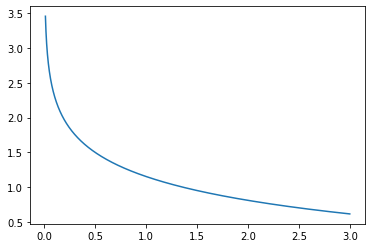

In [ ]:
h = np.linspace(0.01,3,5000)
f_list = []
delta_tau = 0.1
def f(h):
    return -0.5*np.log(np.tanh(delta_tau*h))

for i in h:
    f_list.append(f(i))

plt.plot(h,f_list)

In [ ]:
"""
def trans_metro_step_square(transverse_lattice_dict,T,L,h,delta_tau):
    dimension = len(transverse_lattice_dict)
    gamma = -0.5*np.log(np.tanh(delta_tau*h))

    for i in range(0,Im_L*L*L):

        #print("Im_L is {a}".format(a = Im_L))

        #for i in transverse_lattice_dict.keys():
        #    print(transverse_lattice_dict[i])

        #Im_L_index = np.random.randint(0,Im_L)
        #index = np.random.randint(0,L*L)
        index = np.random.randint(0,L*L*Im_L)

        #print("Im_L_index is {a}".format(a = Im_L_index))
        #print("Index is {a}".format(a = index))

        spin_at_index = transverse_lattice_dict[index]["spin"]

        # 1. Calculate the neighbour sum in same layer
        # calculate how many sites are the same
        Neighbour_sum_same_layer = 0
        for k in transverse_lattice_dict[index]['neighbours']:
            #print("Neigbour spin is {a}".format(a = transverse_lattice_dict[Im_L_index][k]['spin']))
            Neighbour_sum_same_layer += transverse_lattice_dict[k]['spin']

        # 2. Calculate the neighbour sum in differnet layer (along imaginary time axis)
        # calculate how many sites are the same
        up_Im_L_index = (Im_L_index+1)%Im_L
        down_Im_L_index = (Im_L_index-1)%Im_L
        Neighbour_sum_different_layer = transverse_lattice_dict[up_Im_L_index][index]['spin']  + transverse_lattice_dict[down_Im_L_index][index]['spin']

        #3. Add the 2 sum together
        J_x = 1
        beta_cl = delta_tau # just do this for simplicity
        J_y = gamma/beta_cl
        delta_E_same_layer= 2*spin_at_index*Neighbour_sum_same_layer
        delta_E_different_layer = 2*spin_at_index*Neighbour_sum_different_layer
        delta_E = delta_E_same_layer*J_x + delta_E_different_layer*J_y

        #print("Delta E is {delta_E}".format(delta_E=delta_E))
        #print("gamma is {gamma}".format(gamma= gamma))

        # Use a dict to store the result of exp
        weight = np.exp(-delta_E/T)
        #print("Weight is {Weight}".format(Weight=weight))

        if (delta_E < 0) or (np.random.rand() < weight):
            transverse_lattice_dict[Im_L_index][index]["spin"] *= -1
                #print("Flipping occurs")


    return transverse_lattice_dict
"""

'\ndef trans_metro_step_square(transverse_lattice_dict,T,L,h,delta_tau):\n    dimension = len(transverse_lattice_dict)\n    gamma = -0.5*np.log(np.tanh(delta_tau*h))\n\n    for i in range(0,Im_L*L*L):\n\n        #print("Im_L is {a}".format(a = Im_L))\n\n        #for i in transverse_lattice_dict.keys():\n        #    print(transverse_lattice_dict[i])\n\n        #Im_L_index = np.random.randint(0,Im_L)\n        #index = np.random.randint(0,L*L)\n        index = np.random.randint(0,L*L*Im_L)\n\n        #print("Im_L_index is {a}".format(a = Im_L_index))\n        #print("Index is {a}".format(a = index))\n\n        spin_at_index = transverse_lattice_dict[index]["spin"]\n\n        # 1. Calculate the neighbour sum in same layer\n        # calculate how many sites are the same\n        Neighbour_sum_same_layer = 0\n        for k in transverse_lattice_dict[index][\'neighbours\']:\n            #print("Neigbour spin is {a}".format(a = transverse_lattice_dict[Im_L_index][k][\'spin\']))\n            

In [3]:
"""
The following is a new function defined for the transverse field Ising model 1D-array
"""

def trans_metro_step_square(transverse_lattice_dict,T,L,h,delta_tau):
    dimension = len(transverse_lattice_dict)
    gamma = -0.5*np.log(np.tanh(delta_tau*h))

    for i in range(0,dimension):

        #print("Im_L is {a}".format(a = Im_L))

        #for i in transverse_lattice_dict.keys():
        #    print(transverse_lattice_dict[i])

        #Im_L_index = np.random.randint(0,Im_L)
        #index = np.random.randint(0,L*L)
        index = np.random.randint(0,dimension)

        spin_at_index = transverse_lattice_dict[index]["spin"]

        # 1. Calculate the neighbour sum in same layer
        # calculate how many sites are the same
        Neighbour_sum_same_layer = 0
        count_same_layer = 0

        """
        for k in transverse_lattice_dict[index]['neighbours']:
            #print("Neigbour spin is {a}".format(a = transverse_lattice_dict[Im_L_index][k]['spin']))
            Neighbour_sum_same_layer += transverse_lattice_dict[k]['spin']
        """

        while count_same_layer<4: # the first 4 index is the neighbours in same layer
            neighbour_spin_index = transverse_lattice_dict[index]['neighbours'][count_same_layer]
            Neighbour_sum_same_layer += transverse_lattice_dict[neighbour_spin_index]['spin']
            count_same_layer+=1


        # 2. Calculate the neighbour sum in differnet layer (along imaginary time axis)
        # calculate how many sites are the same
        up_Im_L_index = transverse_lattice_dict[index]['neighbours'][4]
        down_Im_L_index = transverse_lattice_dict[index]['neighbours'][5]
        Neighbour_sum_different_layer = (transverse_lattice_dict[up_Im_L_index]['spin'] +
        transverse_lattice_dict[down_Im_L_index]['spin'])

        #3. Add the 2 sum together
        J_x = 1
        beta_cl = delta_tau # just do this for simplicity
        J_y = gamma/beta_cl

        delta_E_same_layer= 2*spin_at_index*Neighbour_sum_same_layer
        delta_E_different_layer = 2*spin_at_index*Neighbour_sum_different_layer
        delta_E = 2*spin_at_index*(Neighbour_sum_same_layer*J_x + Neighbour_sum_different_layer*J_y)

        #print("Delta E is {delta_E}".format(delta_E=delta_E))
        #print("gamma is {gamma}".format(gamma= gamma))

        # Use a dict to store the result of exp
        weight = np.exp(-delta_E*beta_cl) #change this line

        if (delta_E < 0) or (np.random.rand() < weight):
            transverse_lattice_dict[index]["spin"] *= -1
            #print("Flipping occurs")


    return transverse_lattice_dict

In [ ]:
# Test
Temperature = 1
delta_tau = 0.1
L = 4
h = 2.5

beta = 1/Temperature
Im_L = int(beta/delta_tau)

transverse_lattice_dict = gen_lattice_2D_transverse_square_lattice_1D_array(L,Im_L)
transverse_lattice_dict = trans_metro_step_square(transverse_lattice_dict,Temperature,L,h,delta_tau)

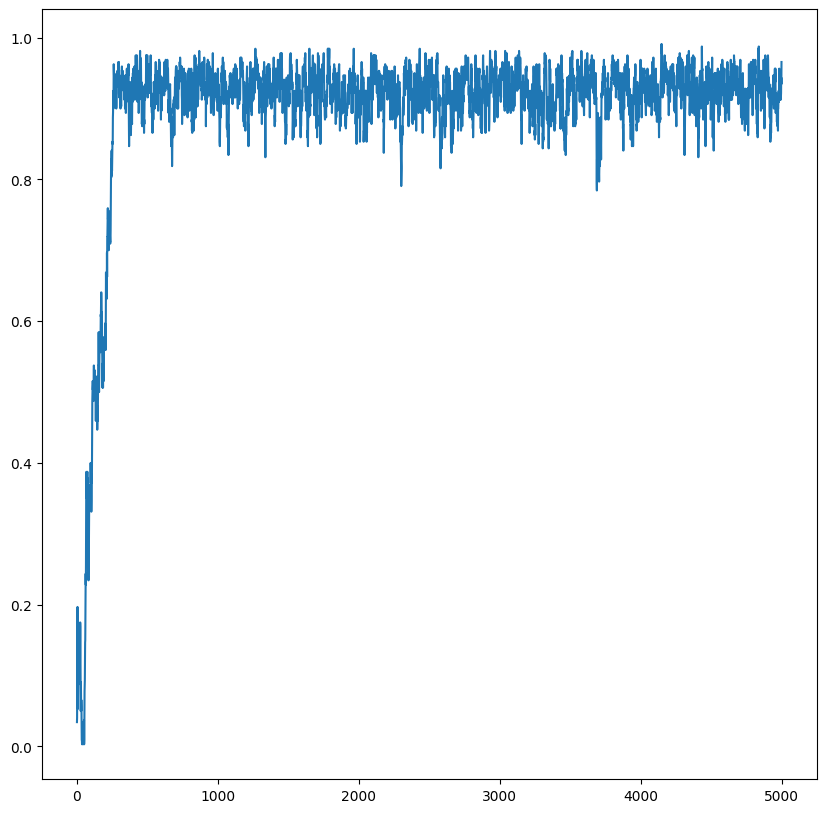

In [ ]:
# Test 2 - Check thermalization value
Temperature = 1
delta_tau = 0.1
L = 8
h = 1.5

beta = 1/Temperature
Im_L = int(beta/delta_tau)

transverse_lattice_dict = gen_lattice_2D_transverse_square_lattice_1D_array(L,Im_L)
AbsMList=[]

for i in range(0,5000):
    transverse_lattice_dict = trans_metro_step_square(transverse_lattice_dict,Temperature,L,h,delta_tau)
    AbsMList.append(transverse_m(transverse_lattice_dict))

plt.figure(figsize=(10,10))
plt.plot(np.arange(0,5000,1), AbsMList)


In [ ]:
print(AbsMList[4900:4999])

[0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375]


In [4]:
"""
Transverse_Metropolis_algorithm

temp_dict has the structure
{"Energy per N":[],"m^2":[],"|m|":[]}

expect_dict has the structure
{"Energy per N":[],"m^2":[],"|m|":[],"specific heat":[],"suspectility":[]}

Parameters
----------

-------

Return
----------


"""

def Transverse_Metropolis_algorithm_at_h(Temperature,iteration,L,h,delta_tau):

#1. Generate equilibrium lattice
  beta = 1/Temperature
  Im_L = int(beta/delta_tau)

  transverse_lattice_dict = gen_lattice_2D_transverse_square_lattice_1D_array(L,Im_L)

  for i in range(10000):
    #trans_metro_step_square(transverse_lattice_dict,T,L,h,delta_tau):
    transverse_lattice_dict = trans_metro_step_square(transverse_lattice_dict,T,L,h,delta_tau)

 #2. Keep on running,collect data
  expect_dict = {"Absolute M":[]}
  sd_dict = {"Absolute M":[]}
  temp_dict={"Absolute M":[]}

  for i in range(iteration):
    transverse_lattice_dict = trans_metro_step_square(transverse_lattice_dict,T,L,h,delta_tau)
    #temp_dict["Energy"].append(Energy(lattice_dict,L))
    #temp_dict["Energy per N"].append(Energy(lattice_dict,L)/(L**2))
    temp_dict["Absolute M"].append(transverse_m(transverse_lattice_dict))
    #temp_dict["M^2"].append(M(lattice_dict,L)**2)

    if((i%100==0) and (i!=0)):
      #print(temp_dict["Absolute M"])
      #print(np.mean(temp_dict["Absolute M"]))
      expect_dict["Absolute M"].append(np.mean(temp_dict["Absolute M"]))
      #expect_dict["suspectility"].append(susceptibility(L,Temperature,temp_dict["Absolute M"]))
      #expect_dict["specific heat"].append(specific_heat(L,Temperature,temp_dict["Energy"]))
      #expect_dict["Energy per N"].append(np.mean(temp_dict["Energy per N"]))

      #clear the dictionary
      temp_dict = temp_dict.fromkeys(temp_dict,[])

  #3. Take mean
  for i in expect_dict.keys():
    sd_dict[i] = np.std(expect_dict[i])
    expect_dict[i] = np.mean(expect_dict[i])

  print("Complete collecting data at h = {h}, T={Temperature}".format(h=h,Temperature=Temperature))

  return expect_dict,sd_dict


In [14]:
L = 6
iteration = 10000
T = 1
h = np.linspace(2.5,3,5)
delta_tau = 0.1

final_mean_dict_transverse_metro_L6 = {"Absolute M":[]}
final_sd_dict_transverse_metro_L6 = {"Absolute M":[]}

for i in range(0,len(h)):
    #Transverse_Metropolis_algorithm_at_h(Temperature,iteration,L,h,delta_tau)
    expect_dict, sd_dict = Transverse_Metropolis_algorithm_at_h(T,iteration,L,h[i],delta_tau)

    for i in expect_dict.keys():
      final_mean_dict_transverse_metro_L6[i].append(float(expect_dict[i]))
      final_sd_dict_transverse_metro_L6[i].append(float(sd_dict[i]))


Complete collecting data at h = 2.5, T=1
Complete collecting data at h = 2.625, T=1
Complete collecting data at h = 2.75, T=1
Complete collecting data at h = 2.875, T=1
Complete collecting data at h = 3.0, T=1


In [ ]:
print(final_mean_dict_transverse_metro_L6)
print(final_sd_dict_transverse_metro_L6)

{'Absolute M': [0.7180187349562024, 0.6572641904541332, 0.6098489209823238, 0.5195837351905617, 0.46816382402651296]}
{'Absolute M': [0.07060606005209291, 0.11019576914906906, 0.11053379361628549, 0.13420176895882427, 0.1287353402508023]}


In [13]:
# For reference,
# Iteration = 20000, take measurements every 10 steps
# Ther = 10000

# Try over 1/sqrt(2000) -> see if the errorbar is small enough

L = 8
iteration = 10000
T = 1
h = np.linspace(2.5,3,5)
delta_tau = 0.1

final_mean_dict_transverse_metro_L8 = {"Absolute M":[]}
final_sd_dict_transverse_metro_L8 = {"Absolute M":[]}

for i in range(0,len(h)):
    #Transverse_Metropolis_algorithm_at_h(Temperature,iteration,L,h,delta_tau)
    expect_dict, sd_dict = Transverse_Metropolis_algorithm_at_h(T,iteration,L,h[i],delta_tau)

    for i in expect_dict.keys():
      final_mean_dict_transverse_metro_L8[i].append(float(expect_dict[i]))
      final_sd_dict_transverse_metro_L8[i].append(float(sd_dict[i]))

Complete collecting data at h = 2.5, T=1
Complete collecting data at h = 2.625, T=1
Complete collecting data at h = 2.75, T=1
Complete collecting data at h = 2.875, T=1
Complete collecting data at h = 3.0, T=1


In [ ]:
"""
#print(final_mean_dict_transverse_metro)
#print(final_sd_dict_transverse_metro)

final_mean_dict_transverse_metro_L8 = {'Absolute M': [0.7156924962468051, 0.6591572875567632, 0.5834635265453237, 0.4996727167547582, 0.4021333725712797]}
final_sd_dict_transverse_metro_L8 = {'Absolute M': [0.06442080929306084, 0.09212418319801352, 0.12035589584678252, 0.14033928415307867, 0.14346120029213608]}
"""

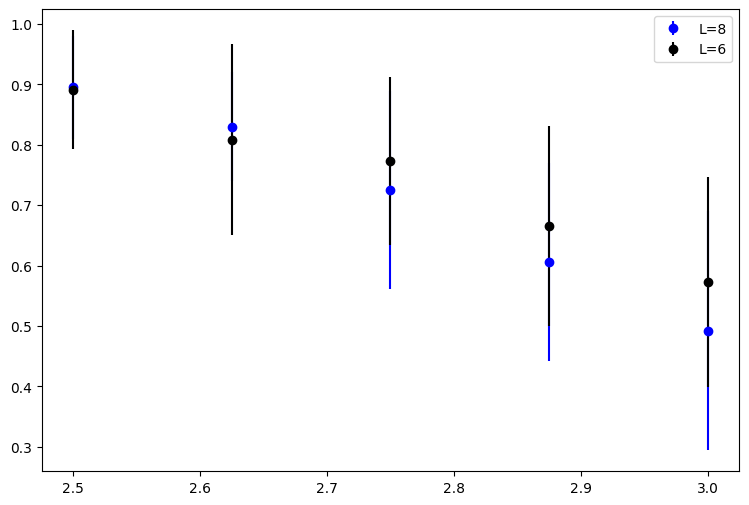

In [15]:
#|m| versus h
beta = 1/8

plt.figure(figsize=(9,6))
plt.errorbar(h,
                np.array(final_mean_dict_transverse_metro_L8["Absolute M"])*L**(beta),
                np.array(final_sd_dict_transverse_metro_L8["Absolute M"])*L**(beta),
                fmt='o',
                color="blue",
             label="L=8")


plt.errorbar(h,
                np.array(final_mean_dict_transverse_metro_L6["Absolute M"])*L**(beta),
                np.array(final_sd_dict_transverse_metro_L6["Absolute M"])*L**(beta),
                fmt='o',
                color="black",
             label="L=6")

#plt.title(r"|m|*L^{\beta} versus h when T = {T}".format(T = T),fontsize=25)
plt.legend()
plt.show()

In [ ]:
def check_thermalization(Temperature,iteration,L,delta_tau,h):
    beta = 1/Temperature
    Im_L = int(beta/delta_tau)
    abs_m_list = []

    transverse_lattice_dict = gen_lattice_2D_transverse_square_lattice(L,Im_L)

    for i in range(iteration):
        #trans_metro_step_square(transverse_lattice_dict,T,L,h,delta_tau)
        transverse_lattice_dict = trans_metro_step_square(transverse_lattice_dict,T,L,h,delta_tau)
        abs_m_list.append(transverse_m(transverse_lattice_dict))

    return abs_m_list

T = 1
iterations = 30000
L = 4
delta_tau = 0.1
h = 2.5
plt.figure(figsize=(20,9))
abs_m_list = check_thermalization(T,iterations,L,delta_tau,h)

plt.plot([i for i in range(0,iterations)],abs_m_list)

plt.xlabel("Number of iterations")
plt.ylabel("|m|")
plt.title("|m| vs number of iterations")
plt.show()

In [ ]:
T = 1
iterations = 1000
L = 4
delta_tau = 0.1
h = 2.85
plt.figure(figsize=(20,9))
abs_m_list = check_thermalization(T,iterations,L,delta_tau,h)

plt.plot([i for i in range(0,iterations)],abs_m_list)

plt.xlabel("Number of iterations")
plt.ylabel("|m|")
plt.title("|m| vs number of iterations")
plt.show()

## 8. Transverse Field Ising Model - SW algorithm

In [ ]:
"""
trans_SW_algo_step_square

Description

Parameters
----------
1. transverse_lattice_dict
2. Temperature
3. L - the length of a square lattice
4. h
5. delta_tau

----------

Return
----------
1. transverse_lattice_dict - the flipped configurations

-------

"""

def trans_SW_algo_step_square(transverse_lattice_dict,Temperature,L,h,delta_tau,Im_L):
    #0. Initialize constant
    gamma = -0.5*np.log(np.tanh(delta_tau*h))
    N = L*L

    #1. Generate bond configuration and set the ["visit"] first

    #print("Before finding bond configuration, ")
    #for i in range(0,len(lattice_dict)):
    #    print(lattice_dict[i])
    #    print("Bond [0] is {a}".format(a = lattice_dict[i]["bond"][0]))

    for i in transverse_lattice_dict.keys():
      transverse_lattice_dict[i]["notvisit"] = True
      transverse_lattice_dict[i]["bond"] = [0,0,0] # [x_down,x_right,y_up]

    beta_cl = delta_tau # just do this for simplicity
    J_x = 1
    J_y = gamma/beta_cl

    same_layer_prob = 1 - np.exp(-2*J_x*beta_cl)
    different_layer_prob = 1 - np.exp(-2*np.abs(J_y)*beta_cl)

    #2. Loop through the lattice and check if it is possible to form bond
    for i in transverse_lattice_dict.keys():

      x_down =  transverse_lattice_dict[i]["neighbours"][3]
      x_right = transverse_lattice_dict[i]["neighbours"][1]
      y_up = transverse_lattice_dict[i]["neighbours"][4]

      # i. Check if it is possible to have link with down sites with prob
      if (transverse_lattice_dict[i]["spin"] == transverse_lattice_dict[x_down]["spin"]) and (np.random.rand() < same_layer_prob):
        transverse_lattice_dict[i]["bond"][0] = 1

        #print(lattice_dict[i]["spin"] == lattice_dict[down]["spin"])
        #print("Current site is  {cs}, it forms bond with {d} (downwards).".format(cs = i, d = down))

      # ii. Check if it is possible to have links with sites right with prob
      if (transverse_lattice_dict[i]["spin"] == transverse_lattice_dict[x_right]["spin"]) and (np.random.rand() < same_layer_prob):
        transverse_lattice_dict[i]["bond"][1] = 1

        #print("Current site is  {cs}, it forms bond with {r} (right).".format(cs = i, r = right))

      # iii. Check if there is link with the sites located upwards (Im_L axis)
      if transverse_lattice_dict[i]["spin"] == transverse_lattice_dict[y_up]["spin"] and (np.random.rand() < different_layer_prob):
        transverse_lattice_dict[i]["bond"][2] = 1

        #print("Current site is  {cs}, it forms bond with {r} (right).".format(cs = i, r = right))

    """
    print("At first, the cluster is: ")
    for i in range(0,len(lattice_dict)):
        print(str(i)+str(lattice_dict[i]))
    """

    #3. change the lattice_dict
    for i in transverse_lattice_dict.keys():

    #print("Now at site {i}".format(i=i))
      if transverse_lattice_dict[i]["notvisit"]:

        if np.random.rand() < 0.5:
          flip_flag = True
          transverse_lattice_dict[i]["spin"] *=-1
          #print("Flip flag is True. Flip {i}".format(i=i))
        else:
          flip_flag = False

        transverse_lattice_dict[i]["notvisit"] = False

        stack_array = np.zeros(N*Im_L)
        stack_array[0] = i
        nstack = 1

        """
        print("Flip flag is: {ff}".format(ff = flip_flag))
        print("Before flipping, the cluster is: ")
        for i in range(0,len(lattice_dict)):
          print(str(i)+str(lattice_dict[i]))
        """

        # Using Breadth-first search (BFS) Algorithm
        while nstack > 0:
          coor = int(stack_array[nstack-1])
          nstack -= 1

          x_left_coor = transverse_lattice_dict[coor]["neighbours"][0]
          x_right_coor = transverse_lattice_dict[coor]["neighbours"][1]
          x_up_coor = transverse_lattice_dict[coor]["neighbours"][2]
          x_down_coor = transverse_lattice_dict[coor]["neighbours"][3]
          y_up_coor = transverse_lattice_dict[coor]["neighbours"][4]
          y_down_coor = transverse_lattice_dict[coor]["neighbours"][5]

          # Check if it has bond with site located downwards in the same layer
          if transverse_lattice_dict[coor]["bond"][0] and (transverse_lattice_dict[x_down_coor]["notvisit"]):
            transverse_lattice_dict[x_down_coor]["notvisit"] = False

            if flip_flag:
              transverse_lattice_dict[x_down_coor]["spin"]*= -1
                            #print("Current position is {cs}, flip downwards {d}".format(cs = coor,d = downwards_coor))

            nstack += 1
            stack_array[nstack-1] = x_down_coor


          # Check if it has bond with site located on the right in the same layer
          if transverse_lattice_dict[coor]["bond"][1] and (transverse_lattice_dict[x_right_coor]["notvisit"]):
            transverse_lattice_dict[x_right_coor]["notvisit"] = False

            if flip_flag:
              transverse_lattice_dict[x_right_coor]["spin"]*= -1
              #print("Current position is {cs}, flip right {r}".format(cs = coor,r =  right_coor))

            nstack += 1
            stack_array[nstack-1] = x_right_coor


          # Check if it has bond with site located upwards in the same layer
          if transverse_lattice_dict[x_up_coor]["bond"][0] and (transverse_lattice_dict[x_up_coor]["notvisit"]):
            transverse_lattice_dict[x_up_coor]["notvisit"] = False

            if flip_flag:
              transverse_lattice_dict[x_up_coor]["spin"]*= -1
              #print("Current position is {cs}, flip up {up}".format(cs = coor,up =  up_coor))

            nstack += 1
            stack_array[nstack-1] = x_up_coor


          # Check if it has bond with site located on the left in the same layer
          if transverse_lattice_dict[x_left_coor]["bond"][1] and (transverse_lattice_dict[x_left_coor]["notvisit"]):
            transverse_lattice_dict[x_left_coor]["notvisit"] = False

            if flip_flag:
              transverse_lattice_dict[x_left_coor]["spin"]*= -1
              #print("Current position is {cs}, flip left {l}".format(cs = coor,l =  left_coor))

            nstack += 1
            stack_array[nstack-1] = x_left_coor

          # Check if it has bond with site located upwards in different layer
          if transverse_lattice_dict[coor]["bond"][2] and (transverse_lattice_dict[y_up_coor]["notvisit"]):
            transverse_lattice_dict[y_up_coor]["notvisit"] = False

            if flip_flag:
              transverse_lattice_dict[y_up_coor]["spin"]*= -1
              #print("Current position is {cs}, flip left {l}".format(cs = coor,l =  left_coor))

            nstack += 1
            stack_array[nstack-1] = y_up_coor


          # Check if it has bond with site located downwards in different layer
          if transverse_lattice_dict[y_down_coor]["bond"][2] and (transverse_lattice_dict[y_down_coor]["notvisit"]):
            transverse_lattice_dict[y_down_coor]["notvisit"] = False

            if flip_flag:
              transverse_lattice_dict[y_down_coor]["spin"]*= -1
              #print("Current position is {cs}, flip left {l}".format(cs = coor,l =  left_coor))

            nstack += 1
            stack_array[nstack-1] = y_down_coor


          #print("Changing, the lattice is: ")
          #print(lattice_dict)

    return transverse_lattice_dict


In [ ]:
"""
SW_algo_at_h

(Description)

Parameters
----------
1. Temperature
2. Iteration
3. L
-------

Return
----------
1. expect_dict,sd_dict  - similar to MC algo

-------

"""
def Transverse_SW_algo_at_h(Temperature,iteration,L,h,delta_tau):

#1. Generate equilibrium lattice
  beta = 1/Temperature
  Im_L = int(beta/delta_tau)

  transverse_lattice_dict = gen_lattice_2D_transverse_square_lattice_1D_array(L,Im_L)

  for i in range(5000):
    transverse_lattice_dict = trans_SW_algo_step_square(transverse_lattice_dict,Temperature,L,h,delta_tau,Im_L)

  print("Finish Thermalization at h = {h}, T = {T}".format(h=h,T=Temperature))

#2. Keep on running,collect data
  expect_dict = {"Absolute M":[]}
  sd_dict = {"Absolute M":[]}
  temp_dict={"Absolute M":[]}

  for i in range(iteration):
    transverse_lattice_dict = trans_SW_algo_step_square(transverse_lattice_dict,Temperature,L,h,delta_tau,Im_L)
    #temp_dict["Energy"].append(Energy(lattice_dict,L))
    #temp_dict["Energy per N"].append(Energy(lattice_dict,L)/(L**2))
    temp_dict["Absolute M"].append(transverse_m(transverse_lattice_dict))
    #temp_dict["M^2"].append(M(lattice_dict,L)**2)

    if((i%100==0) and (i!=0)):
      expect_dict["Absolute M"].append(np.mean(temp_dict["Absolute M"]))
      #expect_dict["suspectility"].append(susceptibility(L,Temperature,temp_dict["Absolute M"]))
      #expect_dict["specific heat"].append(specific_heat(L,Temperature,temp_dict["Energy"]))
      #expect_dict["Energy per N"].append(np.mean(temp_dict["Energy per N"]))

      #clear the dictionary
      temp_dict.fromkeys(temp_dict,[])

  #3. Take mean
  for i in expect_dict.keys():
    sd_dict[i] = np.std(expect_dict[i])
    expect_dict[i] = np.mean(expect_dict[i])

  print("Complete collecting data at h = {h}, T = {Temperature}".format(h=h,Temperature=Temperature))


  return expect_dict,sd_dict

In [ ]:
"""
total_T_h_dict = {  2:[1.3,2],
                    1:[2.6,2.8],
                    0.5: [2.95,3.038],
                    0.25:[2.95,3.038]
                    0.125:[2.95,3.038],
                    0.0625:[2.95,3.038]}
"""

size_list = [8,12,18]
iteration = 30000 # test whether 25000 iterations can produce satisfactory result
T = 0.25
h = np.linspace(2.95,3.037,4)
delta_tau = 0.2

total_mean_dict_transverse_SW = dict()
total_sd_dict_transverse_SW = dict()

size_count = 0

while size_count != len(size_list):
  L = size_list[size_count]
  print("When L = {L},".format(L=L))

  mean_dict_transverse_SW_at_L= {"Absolute M":[]}
  sd_dict_transverse_SW_at_L= {"Absolute M":[]}

  for i in range(0,len(h)):
      expect_dict, sd_dict = Transverse_SW_algo_at_h(T,iteration,L,h[i],delta_tau)

      for i in expect_dict.keys():
        mean_dict_transverse_SW_at_L[i].append(float(expect_dict[i]))
        sd_dict_transverse_SW_at_L[i].append(float(sd_dict[i]))

  total_mean_dict_transverse_SW[L] = mean_dict_transverse_SW_at_L
  total_sd_dict_transverse_SW[L] = sd_dict_transverse_SW_at_L

  size_count+=1

When L = 8,
Finish Thermalization at h = 2.95, T = 0.25
Complete collecting data at h = 2.95, T = 0.25
Finish Thermalization at h = 2.979, T = 0.25
Complete collecting data at h = 2.979, T = 0.25
Finish Thermalization at h = 3.008, T = 0.25
Complete collecting data at h = 3.008, T = 0.25
Finish Thermalization at h = 3.037, T = 0.25
Complete collecting data at h = 3.037, T = 0.25
When L = 12,
Finish Thermalization at h = 2.95, T = 0.25
Complete collecting data at h = 2.95, T = 0.25
Finish Thermalization at h = 2.979, T = 0.25
Complete collecting data at h = 2.979, T = 0.25
Finish Thermalization at h = 3.008, T = 0.25
Complete collecting data at h = 3.008, T = 0.25
Finish Thermalization at h = 3.037, T = 0.25
Complete collecting data at h = 3.037, T = 0.25
When L = 18,
Finish Thermalization at h = 2.95, T = 0.25
Complete collecting data at h = 2.95, T = 0.25
Finish Thermalization at h = 2.979, T = 0.25
Complete collecting data at h = 2.979, T = 0.25
Finish Thermalization at h = 3.008, T 

In [ ]:
# Iteration = 15000
"""
size_list = [8,12,18]
total_mean_dict_transverse_SW = {8: {'Absolute M': [0.4600985934357604, 0.44312649616585864, 0.4294059081953526, 0.41343619455049896, 0.395334988709353, 0.3815449122247879]}, 12: {'Absolute M': [0.4770221130724002, 0.4633065315859563, 0.44455168860699884, 0.4230471202786779, 0.41099621480690973, 0.3820866518947474]}, 18: {'Absolute M': [0.48015228059384435, 0.4529379732990584, 0.42340186098219007, 0.3874438085250673]}}
total_sd_dict_transverse_SW = {8: {'Absolute M': [0.0053191790702972995, 0.005536314276534569, 0.006797874817695325, 0.002918986431857462, 0.0026507936868757445, 0.004615951285393402]}, 12: {'Absolute M': [0.0030178372711066707, 0.003917663744802763, 0.004458579638797905, 0.005264253219629409, 0.003527112417286465, 0.003109874521874299]},18: {'Absolute M': [0.0012249128406437977, 0.0018566941721383998, 0.004151250568483312, 0.007807498997892239]}}
"""

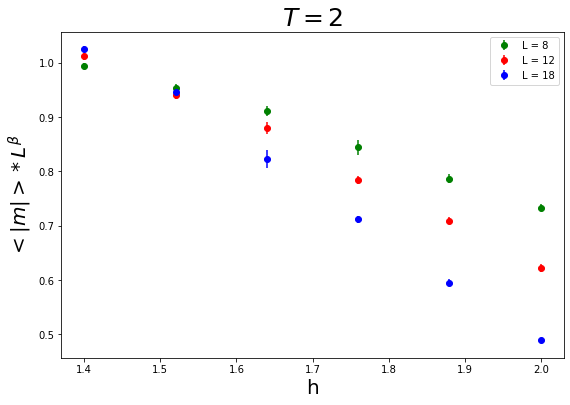

In [ ]:
#|m| versus h
beta = 1/8
colour_list = ["green","red","blue","black","grey"]

#print(len(np.array(total_mean_dict_transverse_SW[L]["Absolute M"])*L**(beta)))
#print(type(h))

plt.figure(figsize=(9,6))
for count, L in enumerate(size_list):
    plt.errorbar(h,
                    np.array(total_mean_dict_transverse_SW[L]["Absolute M"])*L**(beta),
                    np.array(total_sd_dict_transverse_SW[L]["Absolute M"])*L**(beta),
                    fmt='o',
                    color=colour_list[count],
                    label = "L = {L}".format(L=L))


plt.title(rf"$T = {T}$", fontsize=25)
#r"$\chi L^{-\frac{\gamma}{\nu}} $", fontsize=25
plt.ylabel(r"$<|m|>*L^{\beta}$",fontsize=20)
plt.xlabel("h",fontsize=20)
plt.legend()
plt.show()

#print(final_mean_dict_transverse_SW)
#print(final_sd_dict_transverse_SW)

### Check Thermalization values

In [ ]:
"""
def check_thermalization(Temperature,iteration,L,delta_tau,h):
    beta = 1/Temperature
    Im_L = int(beta/delta_tau)
    abs_m_list = []

    transverse_lattice_dict = gen_lattice_2D_transverse_square_lattice(L,Im_L)

    for i in range(iteration):
        #trans_metro_step_square(transverse_lattice_dict,T,L,h,delta_tau)
        transverse_lattice_dict = trans_SW_algo_step_square(transverse_lattice_dict,T,L,h,delta_tau)
        abs_m_list.append(transverse_m(transverse_lattice_dict))

    return abs_m_list

T = 2
iterations = 10
L = 10
delta_tau = 0.1
h = 2.5
plt.figure(figsize=(20,9))
abs_m_list = check_thermalization(T,iterations,L,delta_tau,h)

plt.plot([i for i in range(0,iterations)],abs_m_list)

plt.xlabel("Number of iterations")
plt.ylabel("|m|")
plt.ylim(-1,1)
plt.title("|m| vs number of iterations")
plt.show()
"""

'\ndef check_thermalization(Temperature,iteration,L,delta_tau,h):\n    beta = 1/Temperature\n    Im_L = int(beta/delta_tau)\n    abs_m_list = []\n    \n    transverse_lattice_dict = gen_lattice_2D_transverse_square_lattice(L,Im_L)\n\n    for i in range(iteration):\n        #trans_metro_step_square(transverse_lattice_dict,T,L,h,delta_tau)\n        transverse_lattice_dict = trans_SW_algo_step_square(transverse_lattice_dict,T,L,h,delta_tau)\n        abs_m_list.append(transverse_m(transverse_lattice_dict))\n\n    return abs_m_list\n\nT = 2\niterations = 10\nL = 10\ndelta_tau = 0.1\nh = 2.5\nplt.figure(figsize=(20,9))\nabs_m_list = check_thermalization(T,iterations,L,delta_tau,h)\n\nplt.plot([i for i in range(0,iterations)],abs_m_list)\n\nplt.xlabel("Number of iterations")\nplt.ylabel("|m|")\nplt.ylim(-1,1)\nplt.title("|m| vs number of iterations")\nplt.show()\n'

### Finding the crossing points using poly fit and find roots

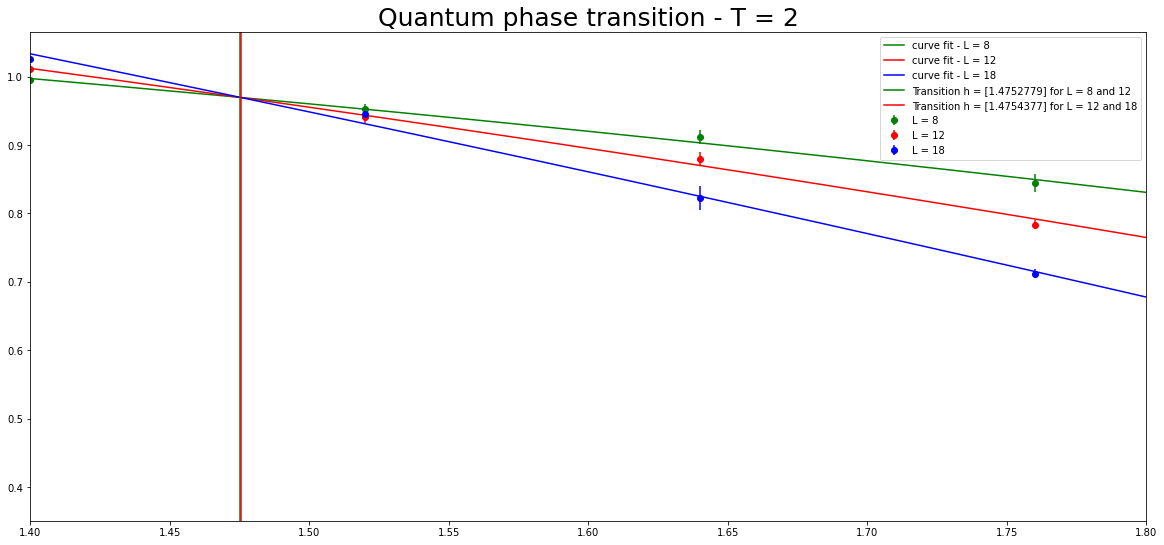

In [ ]:
from scipy.optimize import curve_fit

plt.figure(figsize=(20,9))
plot_h = np.linspace(h.min(),h.max()+0.1,1000)
coefficient_dict_trans = dict()

# 1. Using the cubic polynomial to fit the graph
def quad_function_trans_finite_size(h,B,C,D):
    return B*h**(2) + C*h + D

for count, L in enumerate(size_list):
    # <|m|>*L^{\beta} is the y-axis value
    # h is the x-axis value
    m_L_power_beta_array = (np.array(total_mean_dict_transverse_SW[L]["Absolute M"])*L**(beta))
    B,C,D= curve_fit(quad_function_trans_finite_size,h,m_L_power_beta_array)[0]


    plot_m = B*plot_h**2 + C*plot_h + D


    plt.plot(plot_h,
                plot_m,
                color=colour_list[count],
                label="curve fit - L = {L}".format(L=L))

    coefficient_dict_trans[L] = np.array([B,C,D])

# 2. plot the scatter point
for count, L in enumerate(size_list):
    plt.errorbar(h,
                np.array(total_mean_dict_transverse_SW[L]["Absolute M"])*L**(beta),
                np.array(total_sd_dict_transverse_SW[L]["Absolute M"])*L**(beta),
                fmt='o',
                color=colour_list[count],
                label = "L = {L}".format(L=L))



# 3. Finding the numerical values of the polynomial and plot it in the graph

"""
The temp_coef_array has the structure
[ degree n coef, degree (n-1) coef, ... , degree 0 coefficient]

"""

temp_coef_array_0th = coefficient_dict_trans[size_list[1]] - coefficient_dict_trans[size_list[0]]
temp_coef_array_1st = coefficient_dict_trans[size_list[2]] - coefficient_dict_trans[size_list[1]]
#temp_coef_array_2nd = coefficient_dict_trans[size_list[3]] - coefficient_dict_trans[size_list[2]]

def finding_roots(temp_coef_array,plot_h):

    #x_0[(x_0 > 0) & (x_0 < 4)]
    roots_result = np.roots(temp_coef_array)
    #print(roots_result)
    roots_result = roots_result[(roots_result > h.min()) &(roots_result<h.max())]

    return roots_result

roots_result_0th_and_1st = finding_roots(temp_coef_array_0th,plot_h)
roots_result_1st_and_2nd = finding_roots(temp_coef_array_1st,plot_h)


plt.axvline(roots_result_0th_and_1st, c=colour_list[0],label="Transition h = {h} for L = {L1} and {L2}".format(h = np.round(roots_result_0th_and_1st,7),
                                                                                                L1 = size_list[0],
                                                                                                L2 = size_list[1]))
plt.axvline(roots_result_1st_and_2nd, c=colour_list[1],label="Transition h = {h} for L = {L1} and {L2}".format(h = np.round(roots_result_1st_and_2nd,7),
                                                                                                L1 = size_list[1],
                                                                                                L2 = size_list[2]))
plt.title(f"Quantum phase transition - T = {T}",fontsize=25)
plt.legend()
plt.xlim(1.4,1.8)
plt.savefig(f"QPT_T_{T}_{size_list}.png")


In [ ]:
# Place to print the data and copy and paste to notebook
print(total_mean_dict_transverse_SW)
print(total_sd_dict_transverse_SW)

{8: {'Absolute M': [0.49900213479462485, 0.4810560345274442, 0.4639537601346513, 0.4609333010504144, 0.44850221085690256, 0.44100710834750073, 0.427703384978157, 0.4115775028956536]}, 12: {'Absolute M': [0.4843442907493871, 0.4680383084213427, 0.4557526819203652, 0.4440148765492582, 0.4242139343206648, 0.4087330999926825, 0.38941370132137876, 0.38136628710402815]}, 18: {'Absolute M': [0.4793360509640333, 0.46993633644650407, 0.45009170050764785, 0.431998683872206, 0.41176479328663934, 0.3840280931341361, 0.3595388062703478, 0.34336859333973163]}}
{8: {'Absolute M': [0.008511193967345579, 0.01003815635799266, 0.003698622294810879, 0.006502055417688392, 0.005924011117597001, 0.0034520752665469813, 0.003611166081939609, 0.005906186933478166]}, 12: {'Absolute M': [0.0039692926329218375, 0.005081505303754587, 0.004631347209012925, 0.0030750596446855087, 0.007408666043282411, 0.004166943540794187, 0.006875459764394209, 0.0035274324876211375]}, 18: {'Absolute M': [0.0068699198870534, 0.003979

### Combine all the things together

In [ ]:
def quad_function_trans_finite_size(h,B,C,D):
    return B*h**(2) + C*h + D

In [ ]:
def plot_T_h_function(total_T_h_dict, size_list,division,iteration=3000):
    beta = 1/8


    for T in total_T_h_dict.keys():
        # 0. Initialize some const
        h_lower_bound = total_T_h_dict[T][0]
        h_upper_bound = total_T_h_dict[T][1]
        h = np.linspace(h_lower_bound,h_upper_bound,division)
        delta_tau = 0.1

        total_mean_dict_transverse_SW = dict()
        total_sd_dict_transverse_SW = dict()

        # 1. Simulation using SW algo
        for size_count, L in enumerate(size_list):
            print("When L = {L},".format(L=L))

            mean_dict_transverse_SW_at_L= {"Absolute M":[]}
            sd_dict_transverse_SW_at_L= {"Absolute M":[]}

            for i in range(0,len(h)):
                expect_dict, sd_dict = Transverse_SW_algo_at_h(T,iteration,L,h[i],delta_tau)

                for i in expect_dict.keys():
                    mean_dict_transverse_SW_at_L[i].append(float(expect_dict[i]))
                    sd_dict_transverse_SW_at_L[i].append(float(sd_dict[i]))

            total_mean_dict_transverse_SW[L] = mean_dict_transverse_SW_at_L
            total_sd_dict_transverse_SW[L] = sd_dict_transverse_SW_at_L

        colour_list = ["green","red","blue","black","grey"]

        # 2. Using the cubic polynomial to fit the graph
        from scipy.optimize import curve_fit

        plt.figure(figsize=(20,9))

        plot_h = np.linspace(h_lower_bound,h_upper_bound,1000)
        coefficient_dict_trans = dict()

        for count, L in enumerate(size_list):
            # <|m|>*L^{\beta} is the y-axis value
            # h is the x-axis value
            m_L_power_beta_array = np.array(total_mean_dict_transverse_SW[L]["Absolute M"])*L**(beta)

            print(h)
            print(m_L_power_beta_array)

            B,C,D= curve_fit(quad_function_trans_finite_size,h,m_L_power_beta_array)[0]
            plot_m = B*plot_h**2 + C*plot_h + D


            plt.plot(plot_h,
                            plot_m,
                            color=colour_list[count],
                            label="curve fit - L = {L}".format(L=L))

            coefficient_dict_trans[L] = np.array([B,C,D])

        # 3. plot the scatter point
        for count, L in enumerate(size_list):
            plt.errorbar(h,
                            np.array(total_mean_dict_transverse_SW[L]["Absolute M"])*L**(beta),
                            np.array(total_sd_dict_transverse_SW[L]["Absolute M"])*L**(beta),
                            fmt='o',
                            color=colour_list[count],
                            label = "L = {L}".format(L=L))



        # 4. Finding the numerical values of the polynomial and plot it in the graph

        """
        The temp_coef_array has the structure
        [ degree n coef, degree (n-1) coef, ... , degree 0 coefficient]

        """

        temp_coef_array = coefficient_dict_trans[size_list[1]] - coefficient_dict_trans[size_list[0]]

        try:

            roots_result = np.roots(temp_coef_array)
            roots_result = roots_result[(roots_result > float(plot_h[0])) & (roots_result < float(plot_h[-1]))][0]
            plt.axvline(roots_result, label="Transition h = {h}".format(h = np.round(roots_result,5)))

        except:
            print("The intersection points of 2 sizes have some bugs")

        plt.title(f"Quantum phase transition - T = {T}",fontsize=25)
        plt.legend()
        round_T = int(np.round(T))
        plt.savefig(f"QPT_T_{round_T}.png")
        plt.show()

        print(f"Finish saving the figure when T = {T}")

        total_T_h_dict[T].append(roots_result)

    return total_T_h_dict

In [ ]:
"""
total_T_h_dict = {  0.5:[2.6,3],
                    1:[2.5,2.7],
                    1.5:[2.3,2.65],
                    2:[1.3,1.65]}
"""

total_T_h_dict = { 2:[1.3,1.65],}

size_list = [6,8]
iteration = 5000
division_of_h = 7

#def plot_T_h_function(total_T_h_dict, size_list,division,iteration=3000):
total_T_h_dict = plot_T_h_function(total_T_h_dict,size_list,division_of_h,iteration)

## 9. Transverse Field Algorithm - Wolff Algorithm

The following section is based on 1D array for 2D TFID
- $g_c = 3.04$

In [ ]:
def trans_wolff_step_square_BEF(transverse_lattice_dict,T,L,h,delta_tau,Im_L,same_layer_prob,different_layer_prob):

    random_index = np.random.randint(0,L*L*Im_L)
    Pocket = [random_index]
    Cluster =  [random_index]

    while Pocket != []:
        s = np.random.choice(Pocket)
        for count, l in enumerate(transverse_lattice_dict[s]["neighbours"]):
          if (transverse_lattice_dict[l]["spin"] == transverse_lattice_dict[random_index]["spin"] and
                l not in Cluster and
                np.random.rand() < same_layer_prob and
                count<= 3) or (transverse_lattice_dict[l]["spin"] == transverse_lattice_dict[random_index]["spin"] and
                l not in Cluster and
                np.random.rand() < different_layer_prob and
                count >3):

                Pocket.append(l)
                Cluster.append(l)

        Pocket.remove(s)

    for s in Cluster:
        transverse_lattice_dict[s]["spin"] *= -1

    return transverse_lattice_dict

In [ ]:
def Transverse_wolff_algo_at_h(Temperature,iteration,L,h,delta_tau,thermalization=2000):

#1. Generate equilibrium lattice
  beta = 1/Temperature
  Im_L = int(beta/delta_tau)
  gamma = -0.5*np.log(np.tanh(delta_tau*h))
  beta_cl = delta_tau # just do this for simplicity
  J_x = 1
  J_y = gamma/beta_cl

  #p = 1 - np.exp(-2/Temperature*1)
  same_layer_prob = 1 - np.exp(-2*J_x*beta_cl)
  different_layer_prob = 1 - np.exp(-2*np.abs(J_y)*beta_cl)

  transverse_lattice_dict = gen_lattice_2D_transverse_square_lattice_1D_array(L,Im_L)

  for i in range(thermalization):
    transverse_lattice_dict = trans_wolff_step_square_BEF(transverse_lattice_dict,Temperature,L,h,delta_tau,Im_L,same_layer_prob,different_layer_prob)

  print("Finish Thermalization at h = {h}, T = {T}".format(h=h,T=Temperature))

#2. Keep on running,collect data
  expect_dict = {"Absolute M":[]}
  sd_dict = {"Absolute M":[]}
  temp_dict={"Absolute M":[]}

  for i in range(iteration):
    transverse_lattice_dict = trans_wolff_step_square_BEF(transverse_lattice_dict,Temperature,L,h,delta_tau,Im_L,same_layer_prob,different_layer_prob)
    #temp_dict["Energy"].append(Energy(lattice_dict,L))
    #temp_dict["Energy per N"].append(Energy(lattice_dict,L)/(L**2))
    temp_dict["Absolute M"].append(transverse_m(transverse_lattice_dict))
    #temp_dict["M^2"].append(M(lattice_dict,L)**2)

    if((i%100==0) and (i!=0)):
      expect_dict["Absolute M"].append(np.mean(temp_dict["Absolute M"]))
      #expect_dict["suspectility"].append(susceptibility(L,Temperature,temp_dict["Absolute M"]))
      #expect_dict["specific heat"].append(specific_heat(L,Temperature,temp_dict["Energy"]))
      #expect_dict["Energy per N"].append(np.mean(temp_dict["Energy per N"]))

      #clear the dictionary
      temp_dict.fromkeys(temp_dict,[])

  #3. Take mean
  for i in expect_dict.keys():
    sd_dict[i] = np.std(expect_dict[i])
    expect_dict[i] = np.mean(expect_dict[i])

  print("Complete collecting data at h = {h}, T = {Temperature}".format(h=h,Temperature=Temperature))


  return expect_dict,sd_dict

In [ ]:
"""
total_T_h_dict = {
                    1:[2.5,2.7],
                    2:[1.3,2]
                    0.5: [2.7,2.95]
                    0.25:[2.8,2.95]}
"""

size_list = [10]
iteration = 20000
T = 1
h = np.linspace(2.6,2.75,5) # ~0.05 1 steps
delta_tau = 0.1

total_mean_dict_transverse_wolff = dict()
total_sd_dict_transverse_wolff = dict()

size_count = 0

for L in size_list:
  print("When L = {L},".format(L=L))

  mean_dict_transverse_wolff_at_L= {"Absolute M":[]}
  sd_dict_transverse_wolff_at_L= {"Absolute M":[]}

  for i in range(0,len(h)):
      expect_dict, sd_dict = Transverse_wolff_algo_at_h(T,iteration,L,h[i],delta_t au)

      for i in expect_dict.keys():
        mean_dict_transverse_wolff_at_L[i].append(float(expect_dict[i]))
        sd_dict_transverse_wolff_at_L[i].append(float(sd_dict[i]))

  total_mean_dict_transverse_wolff[L] = mean_dict_transverse_wolff_at_L
  total_sd_dict_transverse_wolff[L] = sd_dict_transverse_wolff_at_L

In [ ]:
#|m| versus h - Wolff
#T = 1
beta = 1/8
colour_list = ["green","red","blue","black","grey"]

plt.figure(figsize=(9,6))
for count, L in enumerate(size_list):
    plt.errorbar(h,
            np.array(total_mean_dict_transverse_wolff[L]["Absolute M"])*L**(beta),
            np.array(total_sd_dict_transverse_wolff[L]["Absolute M"])*L**(beta),
            fmt='o',
            color=colour_list[count],
            label = "L = {L}".format(L=L))


plt.title(rf"$T = {T}$", fontsize=25)
plt.ylabel(r"$<|m|>*L^{\beta}$",fontsize=20)
plt.xlabel("h",fontsize=20)
plt.legend()
plt.show()


## 10. Scaling of thermal transition temperature in the vicinity of quantum critical point

- The Ising transition temperature have the following relation with quantum transition point
$$T_c \propto |g - g_c|^{z \nu} $$
with $z = 1$ and $\nu = \nu_{3D} = 0.62998$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
def quad_function_fitting(x,A,B,C):
    return A*x**(2) + B*x + C

We need to use crossing point analysis again to obtain the h values

c:\Users\timch\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


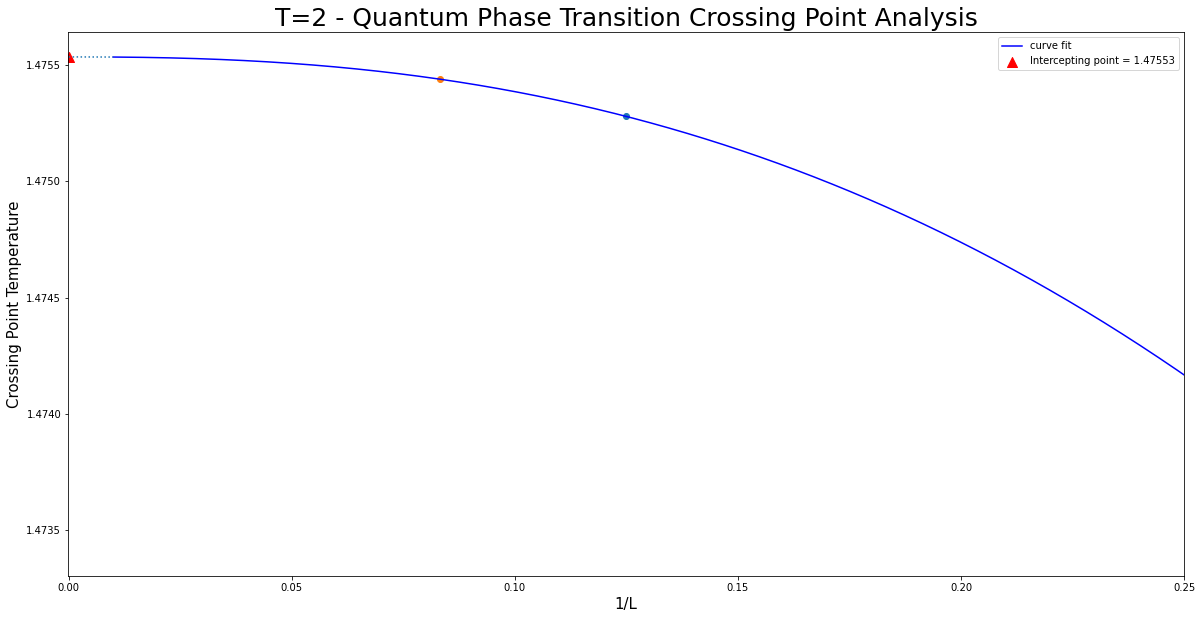

In [ ]:

size_array_QPT = np.array([8,12])
T_crossing_point_array = np.array([1.4752779, 1.4754377])

def T_function(L,T_c,a):
    index = (1/nu + omega)
    return T_c + a*L**(-index)

# T_crossing_point_array is the y-value
# np.array(size_list[:-1:]) is the x-value

nu = 0.629971
omega = 0.82966
T_c, a = curve_fit(T_function, size_array_QPT, T_crossing_point_array)[0]
one_over_L = np.linspace(0.01,0.3,1000)
plot_T_star = T_c + a*one_over_L**(1/nu + omega)

plt.figure(figsize=(20,10))
plt.plot(one_over_L,plot_T_star,color ="blue",label="curve fit")

plt.plot([0,one_over_L[0]],[T_c,plot_T_star[0]],linestyle='dotted')
plt.scatter([0],[T_c],s=100,label="Intercepting point = {T_c}".format(T_c=np.round(T_c,5)),marker='^',color = "red")

plt.legend()
plt.xlim(-0.0001,0.25)
plt.title("T=2 - Quantum Phase Transition Crossing Point Analysis",size=25)
plt.xlabel("1/L",size=15)
plt.ylabel("Crossing Point Temperature",size=15)


for i in range(len(size_array_QPT)):
    x = (1/size_array_QPT)[i]
    y = np.abs(T_crossing_point_array[i])
    plt.scatter(x,y)

plt.savefig("T=2 Crossing Point Analysis QPT")


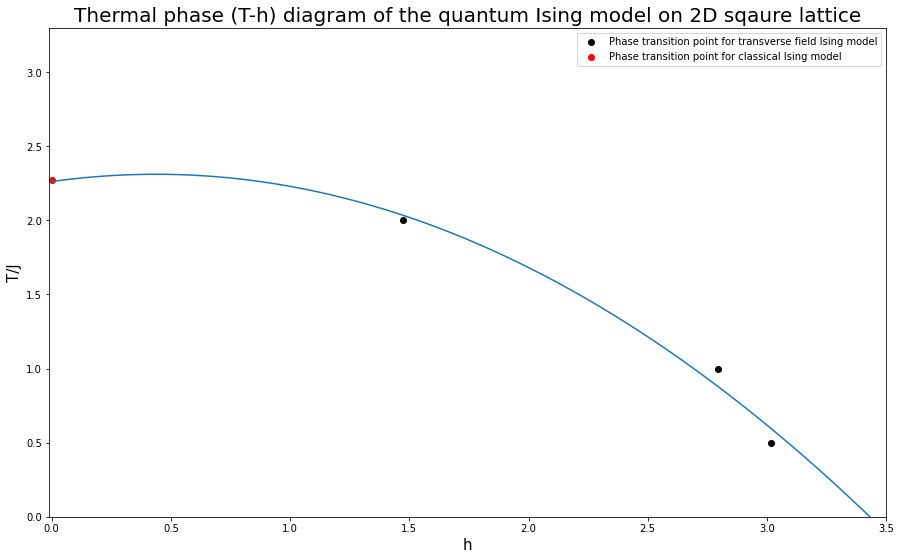

In [ ]:
from scipy.optimize import curve_fit

# 1. Extract the data from the graph produced
T_c_list = np.array([2.269,0.5, 1, 2])
h_bound_list = np.array([0,3.01809,2.79315,1.47553])

# 2. Fitting the graph
A,B,C= curve_fit(quad_function_fitting,h_bound_list,T_c_list)[0]
plot_h_bound = np.linspace(0,3.5,1000)

# 3. Plot the graph
plt.figure(figsize=(15,9))
plot_T_c = quad_function_fitting(plot_h_bound,A,B,C) # numpy array can be put into self-defined function directly
plt.plot(plot_h_bound ,plot_T_c)
plt.scatter(h_bound_list[1::],T_c_list[1::],color="black",marker="o",label="Phase transition point for transverse field Ising model")
plt.scatter(h_bound_list[0],T_c_list[0],color="red",marker="o",label="Phase transition point for classical Ising model")
plt.xlim(-0.01,3.5)
plt.ylim(0,3.3)
plt.xlabel("h",fontsize=15)
plt.ylabel("T/J",fontsize=15)
plt.title("Thermal phase (T-h) diagram of the quantum Ising model on 2D sqaure lattice",fontsize=20)
plt.legend()
plt.savefig("T_h diagram")

In [ ]:
# 4. Finding the roots
quantum_transition_point = np.roots(np.array([A,B,C]))
h_c = quantum_transition_point[(quantum_transition_point > 2.8) & (quantum_transition_point < 3.5)][0]

print(f"The quantum transition points obtained by poly fitting is {h_c}")

The quantum transition points obtained by poly fitting is 3.431772502232401


The product of v and z is 0.31336146447844615
k is 1.6453810427769304


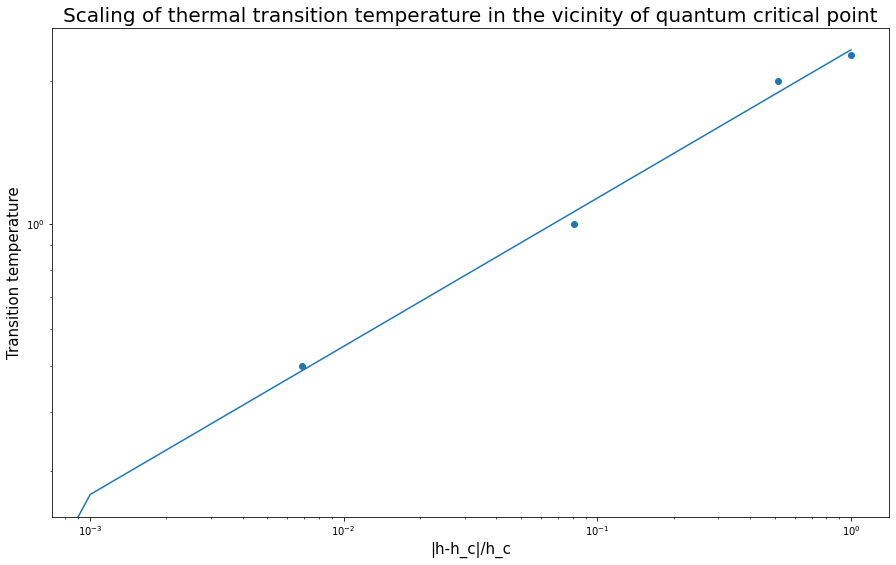

In [ ]:
# plot T_c versus |h-h_c|/h_c

h_c = 3.039
h_c_list = np.abs(h_bound_list - h_c)/h_c

plt.figure(figsize=(15,9))
plt.scatter(h_c_list,T_c_list)

# fitting the points and find the critical exponents
def scaling_relaton(h,v_times_z,k):
    h_c = 3.039
    return k*np.power(np.abs(h - h_c),v_times_z)

from scipy.optimize import curve_fit
v_times_z,k = curve_fit(scaling_relaton,h_bound_list,T_c_list)[0]

print(f"The product of v and z is {v_times_z}")
print(f"k is {k}")

plot_h_bound = np.linspace(h_c,h_c*2,1000)
plot_T = scaling_relaton(plot_h_bound,v_times_z, k)
plt.plot((plot_h_bound-h_c)/h_c,plot_T)
plt.title("Scaling of thermal transition temperature in the vicinity of quantum critical point",fontsize=20)
plt.ylabel("Transition temperature",size=15)
plt.xlabel("|h-h_c|/h_c",size=15)
plt.yscale("log")
plt.xscale("log")
plt.savefig("Scaling of thermal transition temperature in the vicinity of quantum critical point")